In [99]:
import json
import munch
import numpy as np
import equations as eqn
import matplotlib.pyplot as plt
from IPython.display import Markdown, Latex, display
import scipy.stats as sts
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

config_path = r'/Users/arashfahim/Documents/Corporate-Governance-and-Asset-Pricing/Jupyter_data'





# Parameters

In [100]:
config_dict = {
        "Parameters": {
        "\u03bc:": 1.2,
        "\u03b3:": 0.2,
        "r:": 0.1,
        "\u03bb": 0.8,
        "\u03c3:": [
        0.2,
        0.1
        ],
        "\u03c1:": [
        0.0,
        0.1,
        ]
        },
        "Numerical_settings": {
        "range": 10.0,
        "Number_of_points": 2000,
        "df0": 5,
        "Stop_criterion_for_F_ODE": 0.001,
        "Upper_dy_lim": 1000,
        "Lower_dy_lim": 0.1,
        "num_iterations": 200
        },
        "color": "green"
        }

In [101]:
config = munch.munchify(config_dict)
config

Munch({'Parameters': Munch({'μ:': 1.2, 'γ:': 0.2, 'r:': 0.1, 'λ': 0.8, 'σ:': [0.2, 0.1], 'ρ:': [0.0, 0.1]}), 'Numerical_settings': Munch({'range': 10.0, 'Number_of_points': 2000, 'df0': 5, 'Stop_criterion_for_F_ODE': 0.001, 'Upper_dy_lim': 1000, 'Lower_dy_lim': 0.1, 'num_iterations': 200}), 'color': 'green'})

# Soving the ODEs

In [102]:
PA_list=[]

PA_tmp = getattr(eqn, "eqn_FfS")(config)
print('[mu, gamma, r ,lmb ,sgm, rho]: ',PA_tmp.param)
PA_tmp.bvp()
print(PA_tmp.message)
PA_list.append(PA_tmp)

Switching values and active regimes:
 
0  to  1  at Gamma_ 1  =  -6.667  

[mu, gamma, r ,lmb ,sgm, rho]:  [1.2, 0.2, 0.1, 0.8, [0.2, 0.1], [0.0, 0.1]]
var =  1e-05        Iteration =  49


/opt/anaconda3/lib/python3.11/site-packages/scipy/integrate/_bvp.py:1093: RuntimeWarning: invalid value encountered in divide
  r_middle = 1.5 * col_res / h
/opt/anaconda3/lib/python3.11/site-packages/scipy/integrate/_bvp.py:591: RuntimeWarning: invalid value encountered in divide
  slope = (y[:, 1:] - y[:, :-1]) / h


BVP for S is solved in 1.147546 seconds.

BVP for T is solved in 1.109765 seconds.

BVP for C is solved in 1.208481 seconds.


This solves the value function as a function of w, the agent's utility.

If the three numbers below, approximations of payment boundary by three methods,are almost equal, the scheme is working. 
Otherwise, reset df0 in the json file and run the code again.
Calculation of payment boundary by three methods: 
Minimum of abs(F-(mu-gamma*x)/r,  Minimum of abs(dF+1), and Minimum of abs(ddF) are, respectively, at
0.70535, 0.70535, and 0.70535. 
The value of dF(0) is 90.27414. 
If the principal has the bargaining power, the minimum utility of the agent is 0.4002.
The initial capital to start implemeting the contract is 0.50025.  
The divident boundary is given by 0.88794. 
The switching point(s) are given by 0.48.


In [103]:
SOL = PA_list[0]

In [104]:
SOL.optimal([0.02])

(array([0.1]), array([0.1]))

# Simulation of paths

In [105]:
def indicator(X):
    i = 0
    a = np.zeros(X.shape)
    while (i<X.shape[0]) and (X[i]>0):
        a[i] = X[i]
        i += 1
    X[:] = a

In [106]:
def simulate_M(PA,m0,T,N):
    dt = T/N
    gamma = PA.param[1]
    lb = PA.param[3]
    sigma = PA.optimal
    X = np.array([m0])
    shape = len(m0)
    for i in range(2,N+1):
        val = X[-1] + (gamma*X[-1])*dt + sigma(lb*X[-1])[0]*np.sqrt(dt)*np.random.normal(size=shape)
        # val = X[-1] + np.sqrt(dt)*np.random.normal(size=shape)# for testing Brownian motion is used
        val = PA.m_p - np.abs(PA.m_p - val)
        X = np.append(X,val)
        X = X.reshape(i,-1)
    return np.transpose(X)
    

In [107]:
T=50
N=5000
J=10000
M = simulate_M(SOL,[SOL.m_s]*J,T,N)
M.shape

(10000, 5000)

In [108]:
for i in range(M.shape[0]):
    indicator(M[i,:])
M.shape   


(10000, 5000)

In [109]:
S = SOL.solution_S.sol(M)[0]
ES = S.mean(axis=0)
STD_S = np.sqrt((S*S).mean(axis=0))
m_p = SOL.m_p
m_s = SOL.m_s
swtch = SOL.m[SOL.swtch_pos]
Sp = SOL.solution_S.sol(M)[1]
lb = SOL.param[3]
PPS = lb/Sp


In [110]:
len(np.random.randint(0,10000,(5)))

5

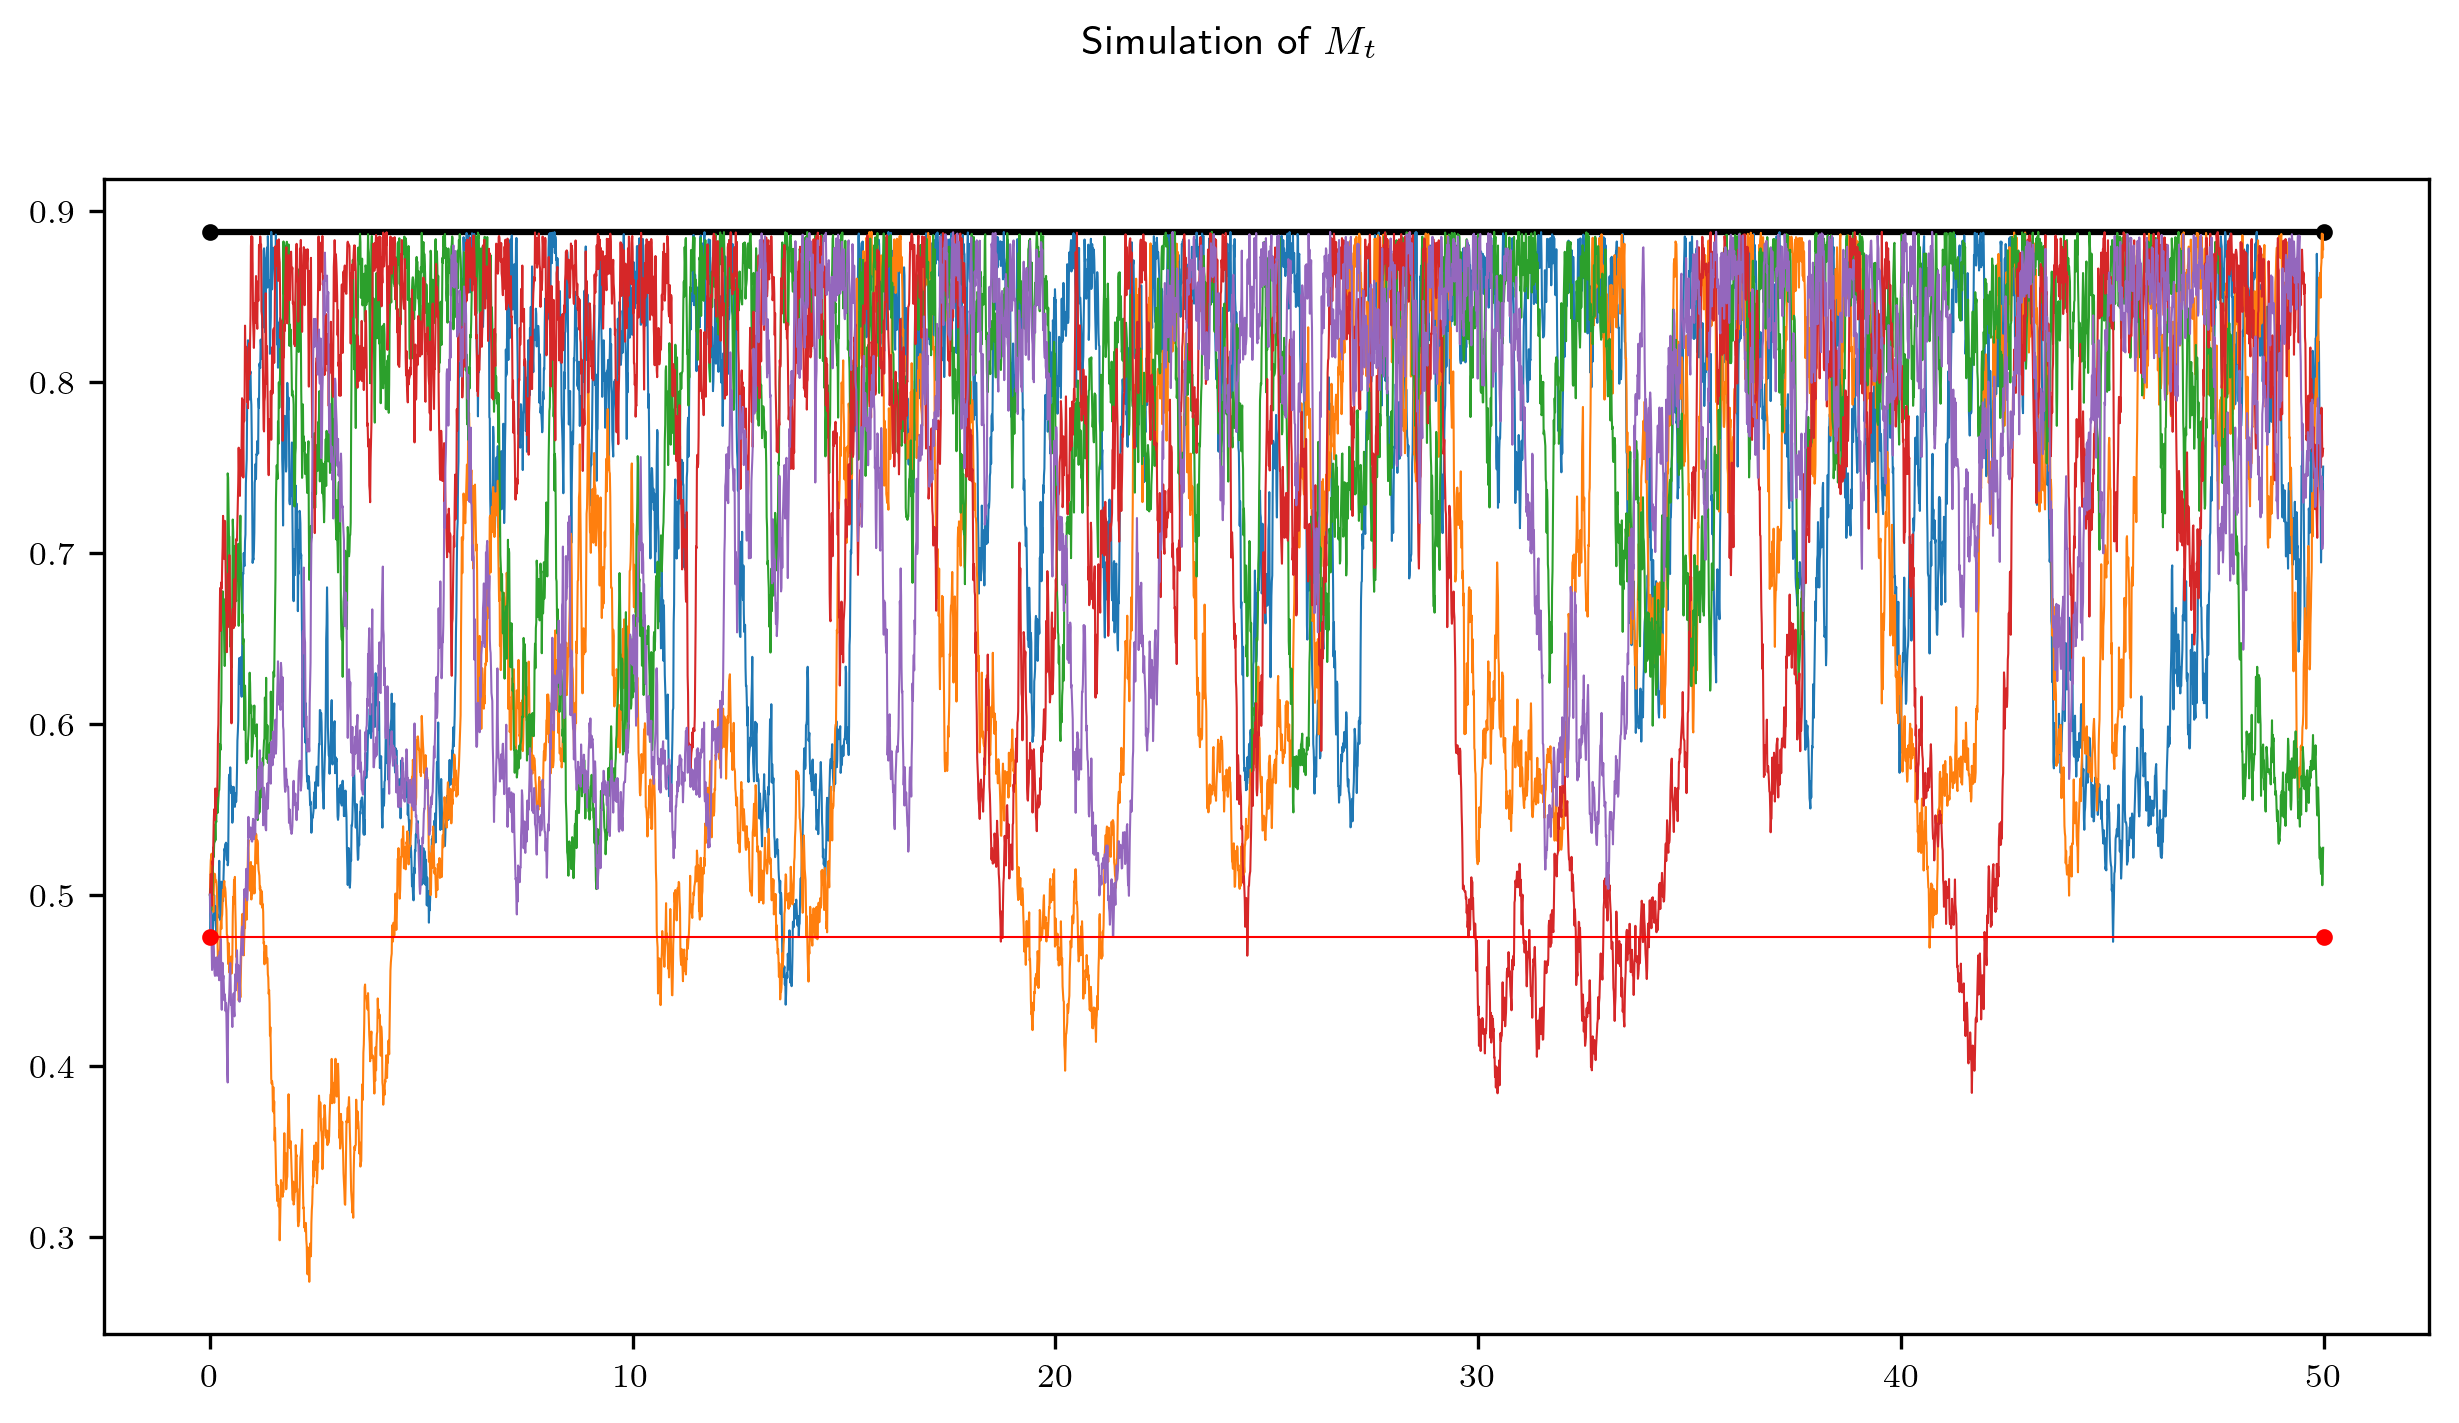

In [111]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot([0,T],[m_p]*2,'k.-')
plt.plot(np.arange(0,T,T/N),np.transpose(M[np.random.randint(0,10000,(5)),:]),linewidth=0.5)    
for s in swtch:
    plt.plot([0,T],[s]*2,'r.-', linewidth=0.5)    
f.suptitle(r'Simulation of $M_t$');
# plt.tight_layout();

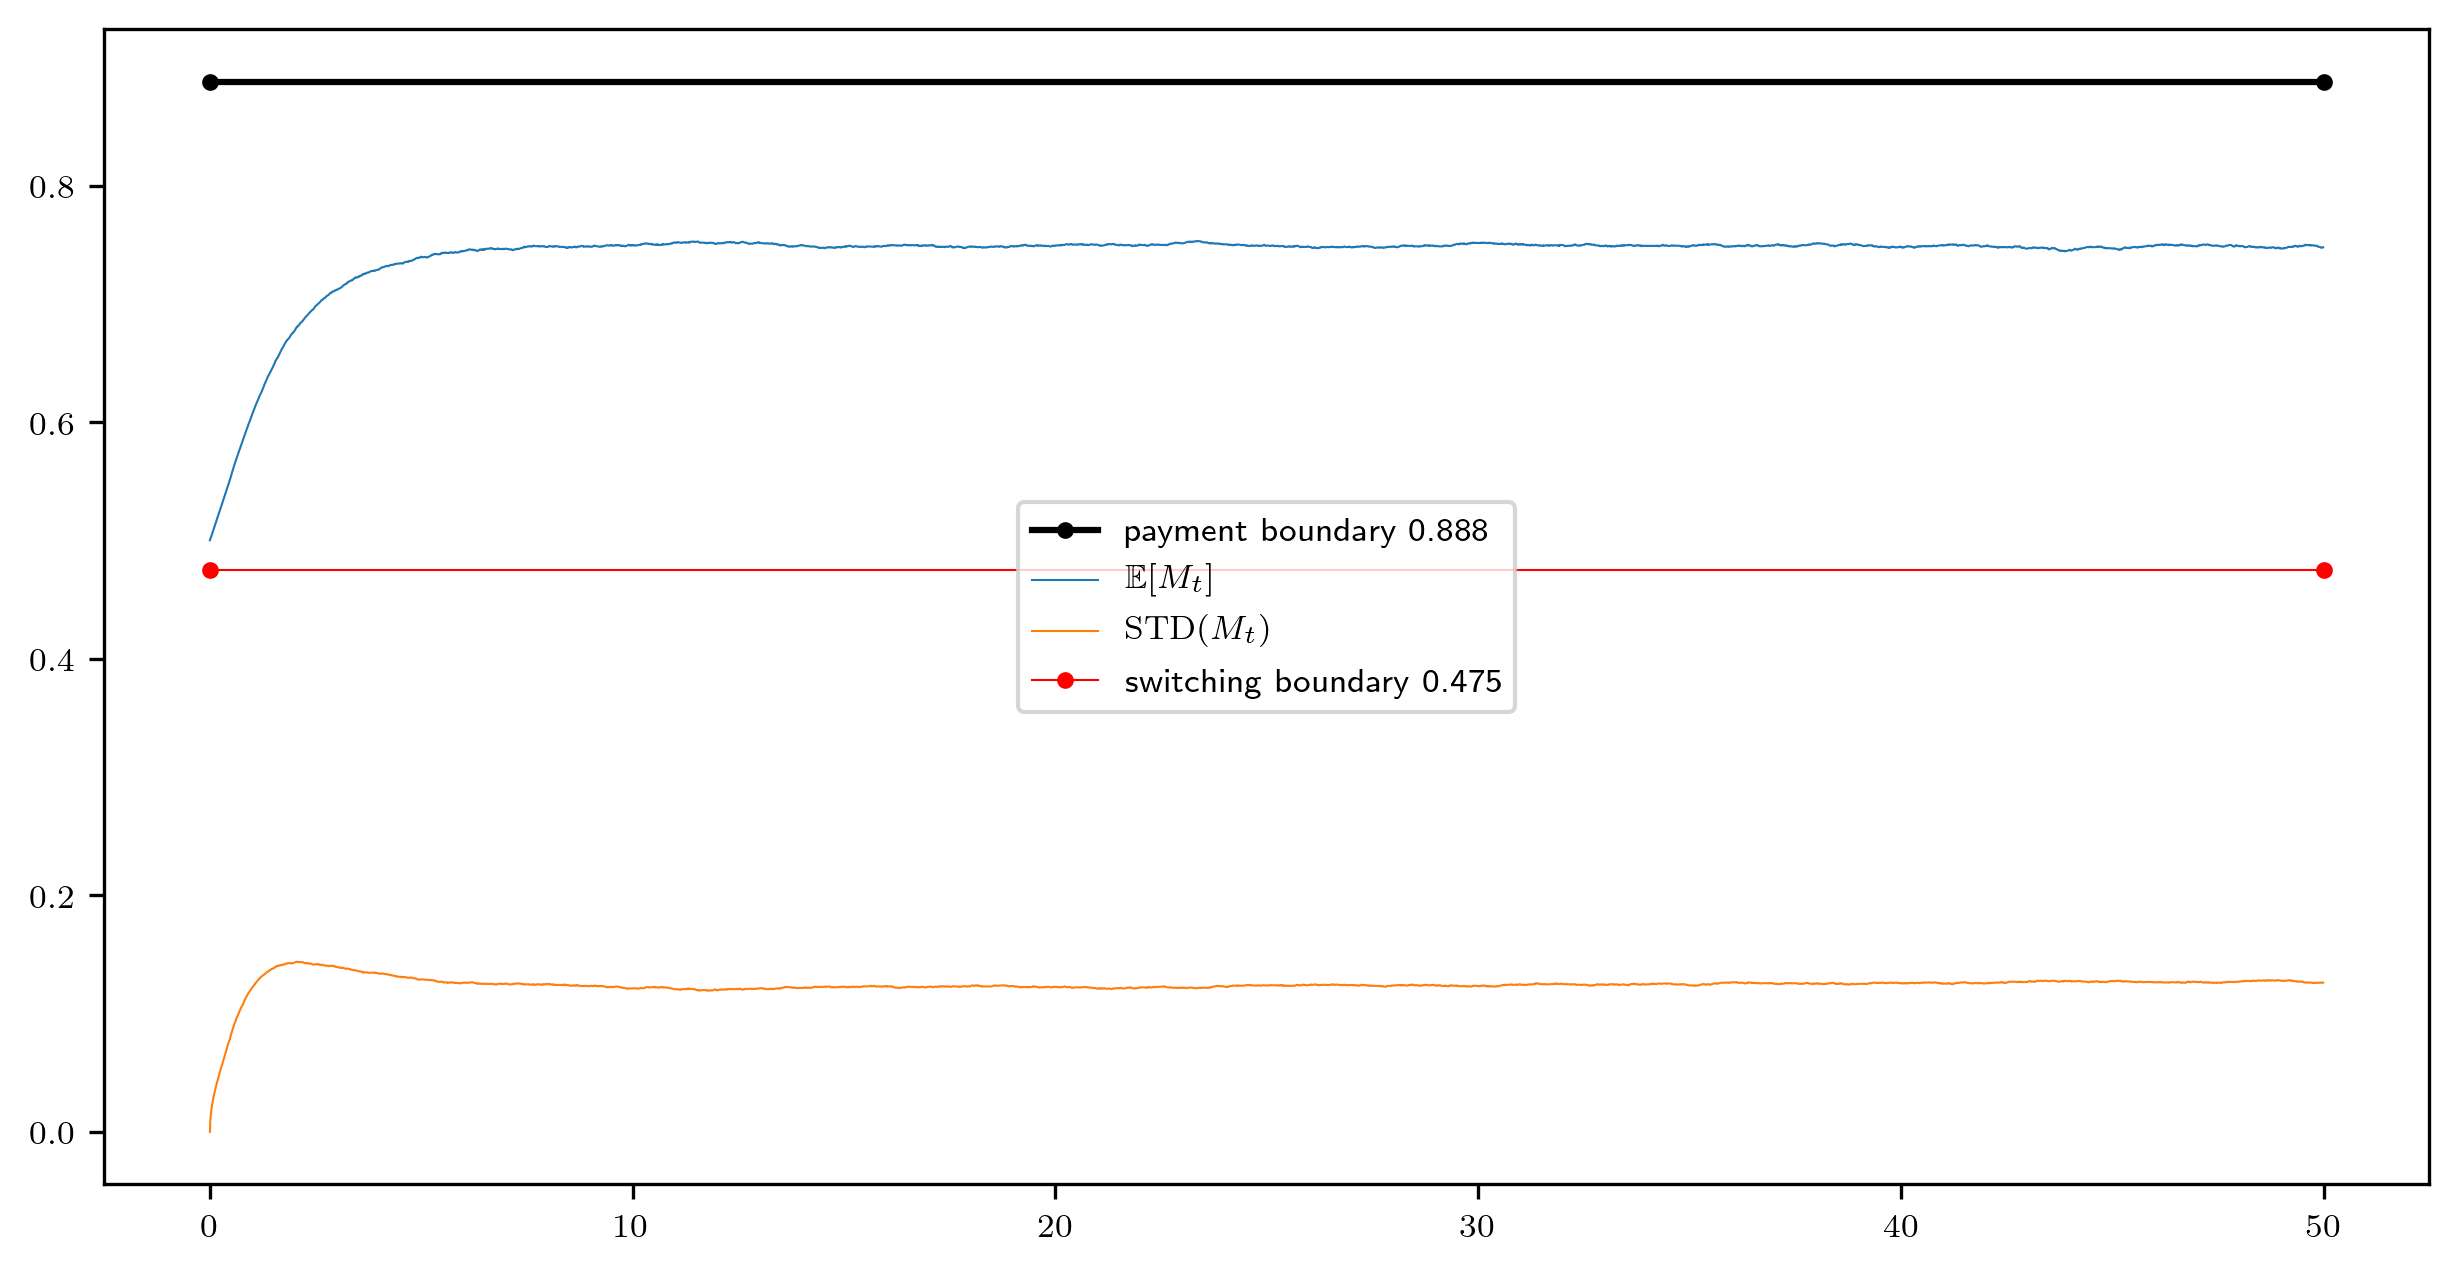

In [112]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot([0,T],[m_p]*2,'k.-', label=r'payment boundary {}'.format(str(np.round(m_p,3))))
plt.plot(np.arange(0,T,T/N),M.mean(axis=0),linewidth=0.5, label=r'$\mathbb{E}[M_t]$')
plt.plot(np.arange(0,T,T/N),M.std(axis=0),linewidth=0.5 , label=r'$\textrm{STD}(M_t)$')
for s in swtch:
    plt.plot([0,T],[s]*2,'r.-', linewidth=0.5, label='switching boundary {}'.format(str(np.round(s,3))))
# f.suptitle(r'Simulation of $M_t$');
plt.legend();

In [113]:
def hist_plot(n):#n=N/100
    f = plt.figure(figsize=(10,10), dpi=400)
    f.suptitle(r'pdf of $M_t$ at different times')
    for i in range(0,N,n):
        if i!= 0 :
            samples = M[:,i]
            x = np.linspace(0, m_p)
            kde = sts.gaussian_kde(samples)
            plt.plot(x, kde.pdf(x),  lw=1,label=str(i*T/N))
    samples = M[:,-1]    
    kde = sts.gaussian_kde(samples)
    plt.plot(x, kde.pdf(x),  lw=1, label=str(T))
    plt.legend();
    

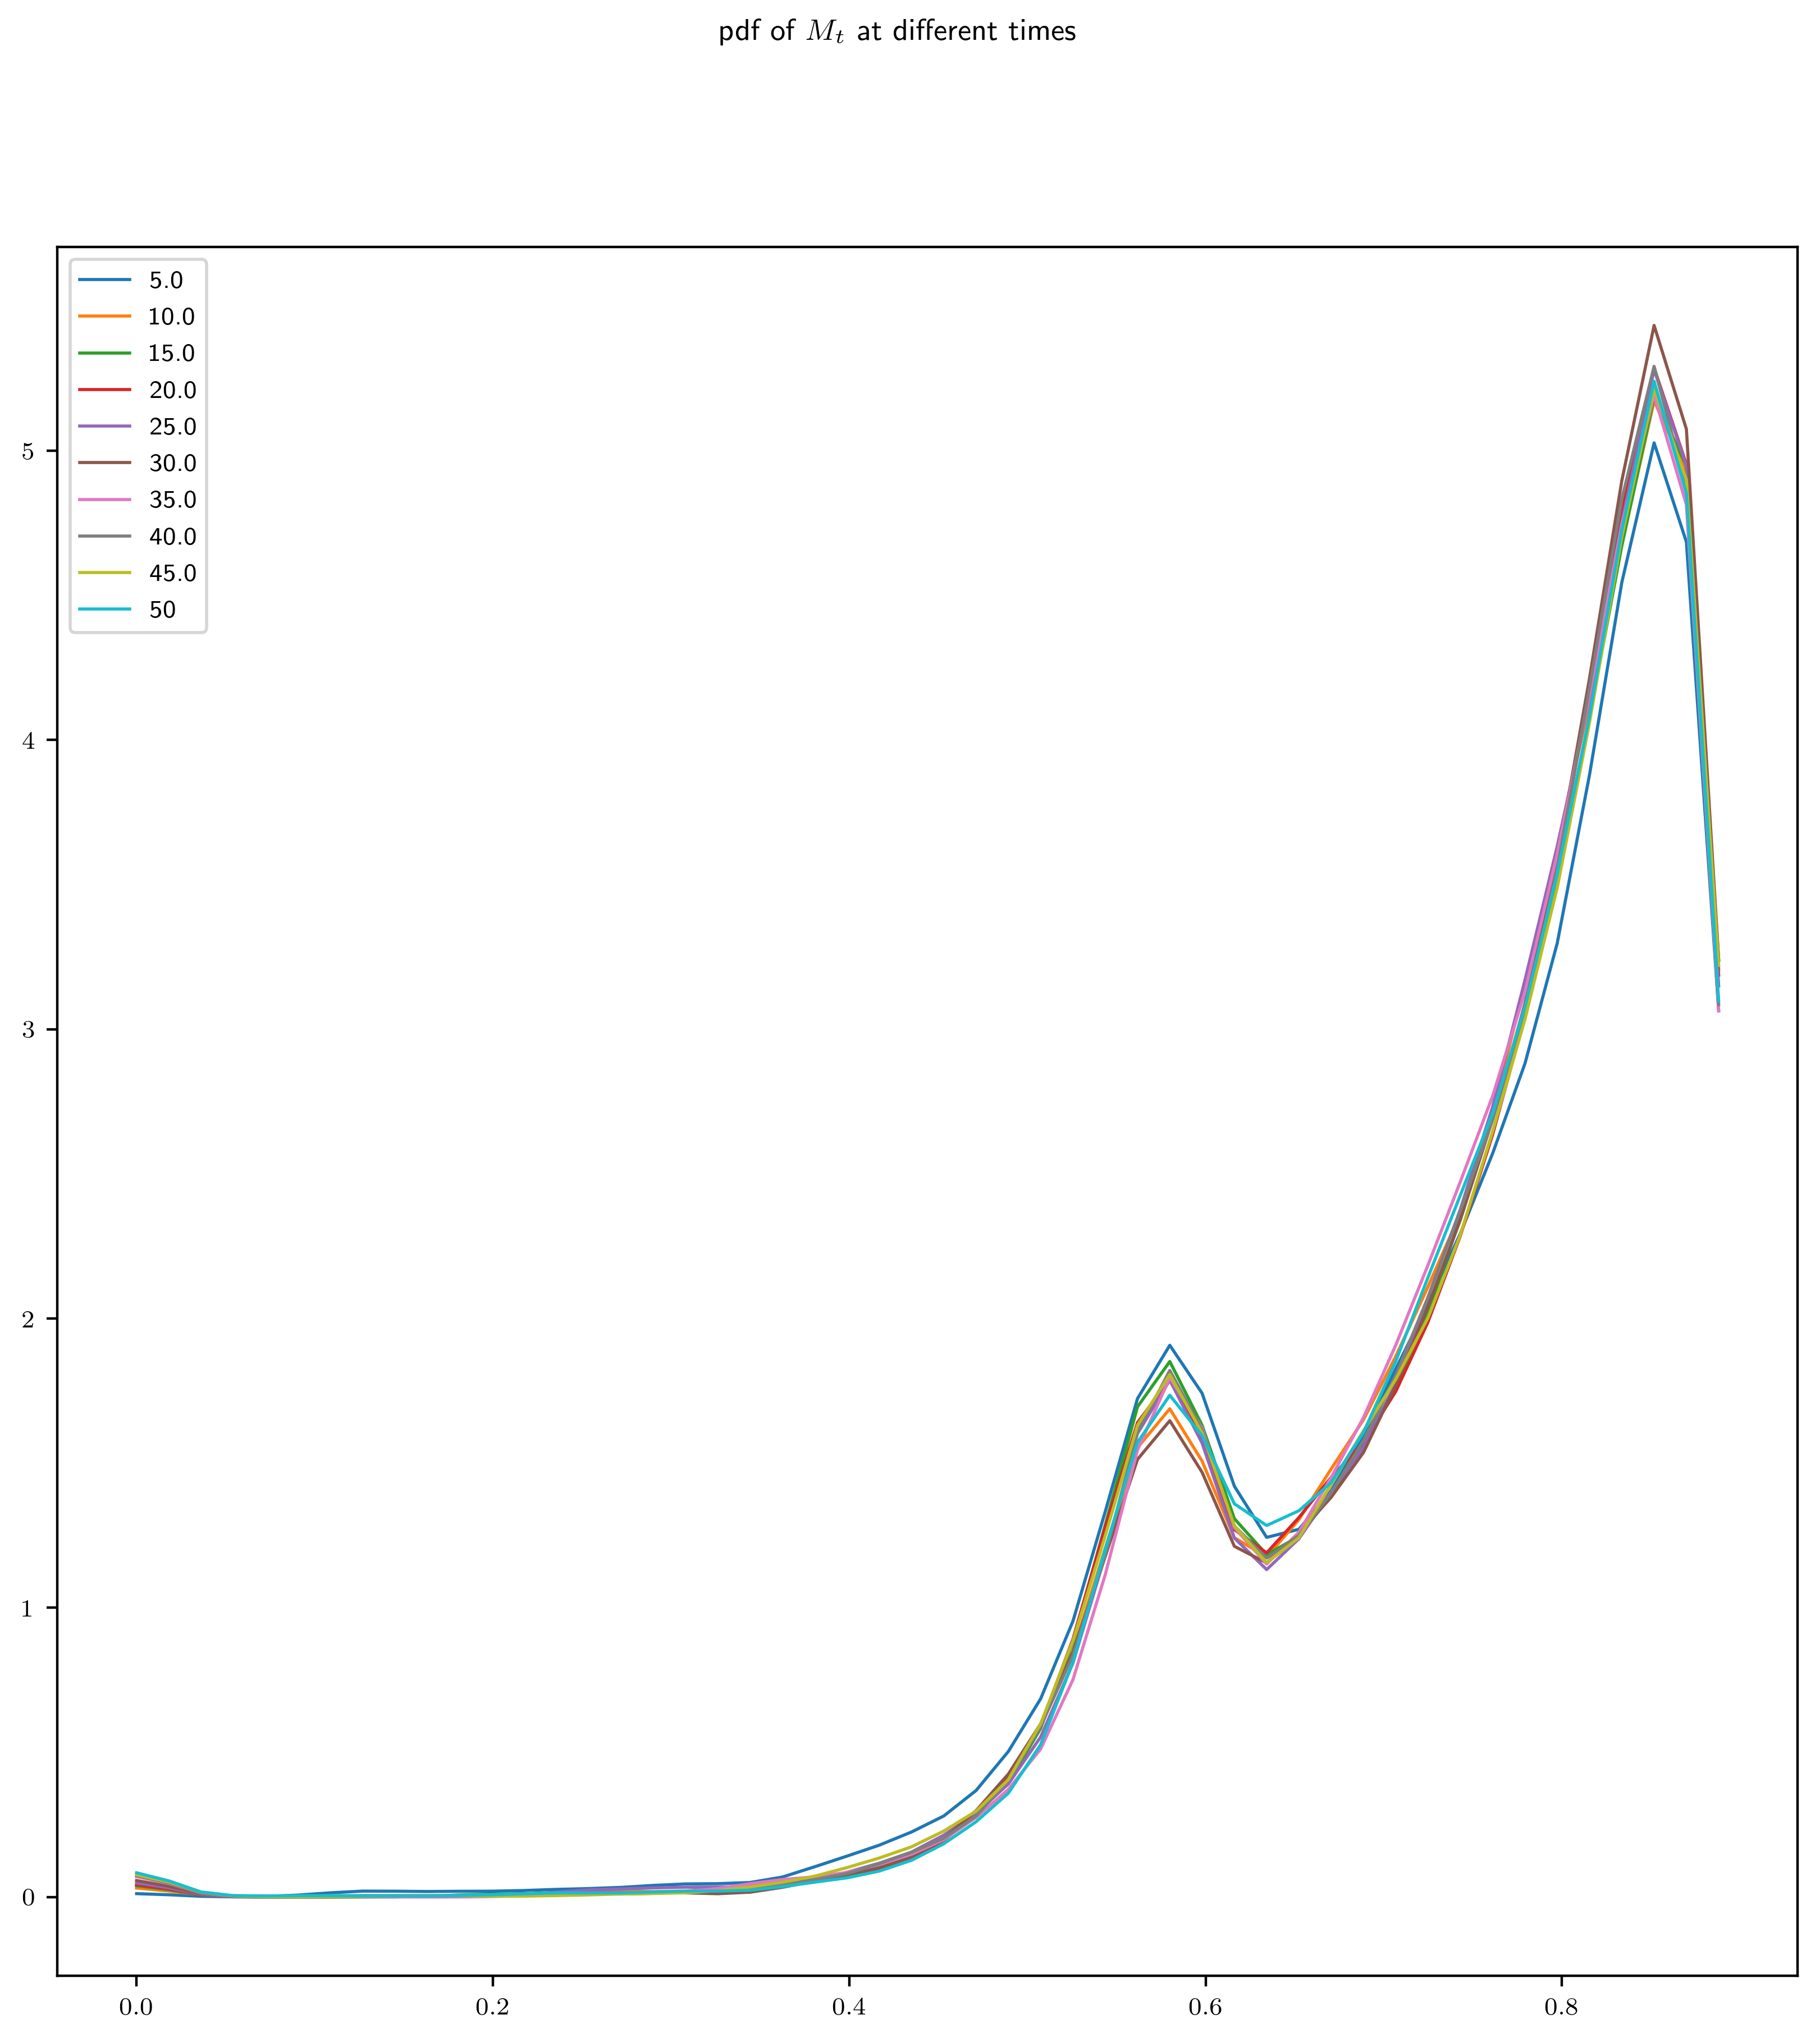

In [114]:
hist_plot(500)

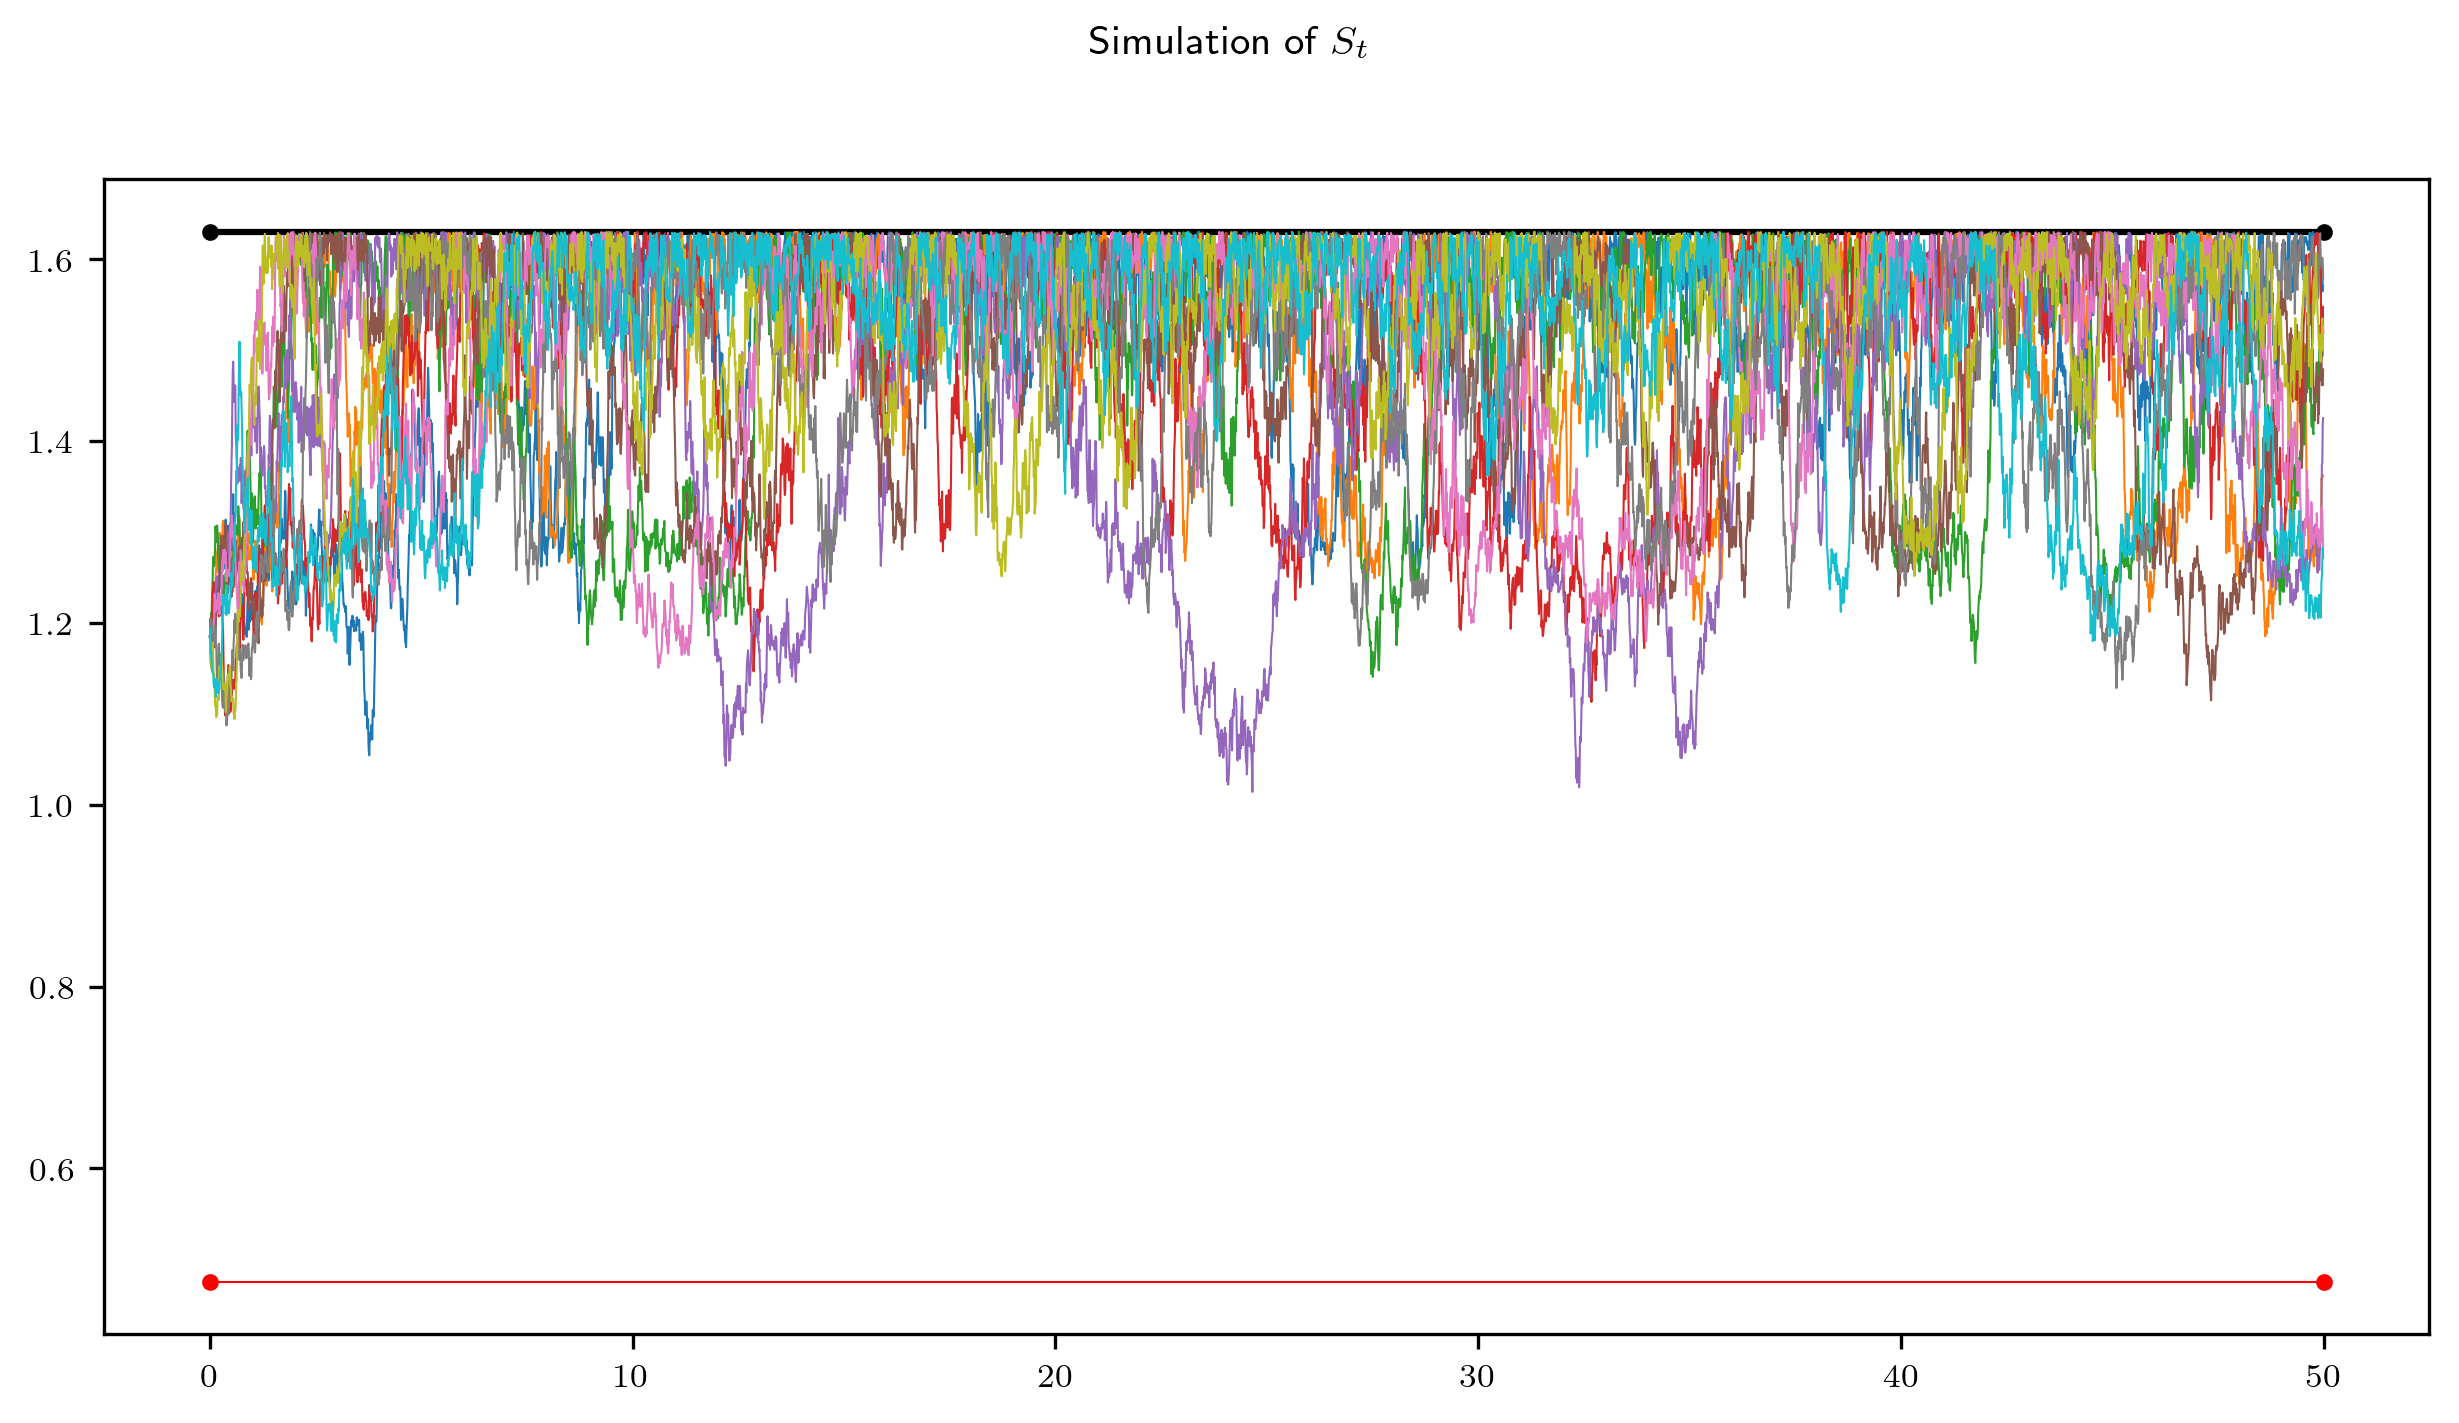

In [115]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot([0,T],[SOL.solution_S.sol(m_p)[0]]*2,'k.-')
plt.plot(np.arange(0,T,T/N),np.transpose(S[np.random.randint(0,1000,(10)),:]),linewidth=0.5 )
for s in swtch:
    plt.plot([0,T],[s]*2,'r.-', linewidth=0.5)    
f.suptitle(r'Simulation of $S_t$');
# plt.tight_layout();    


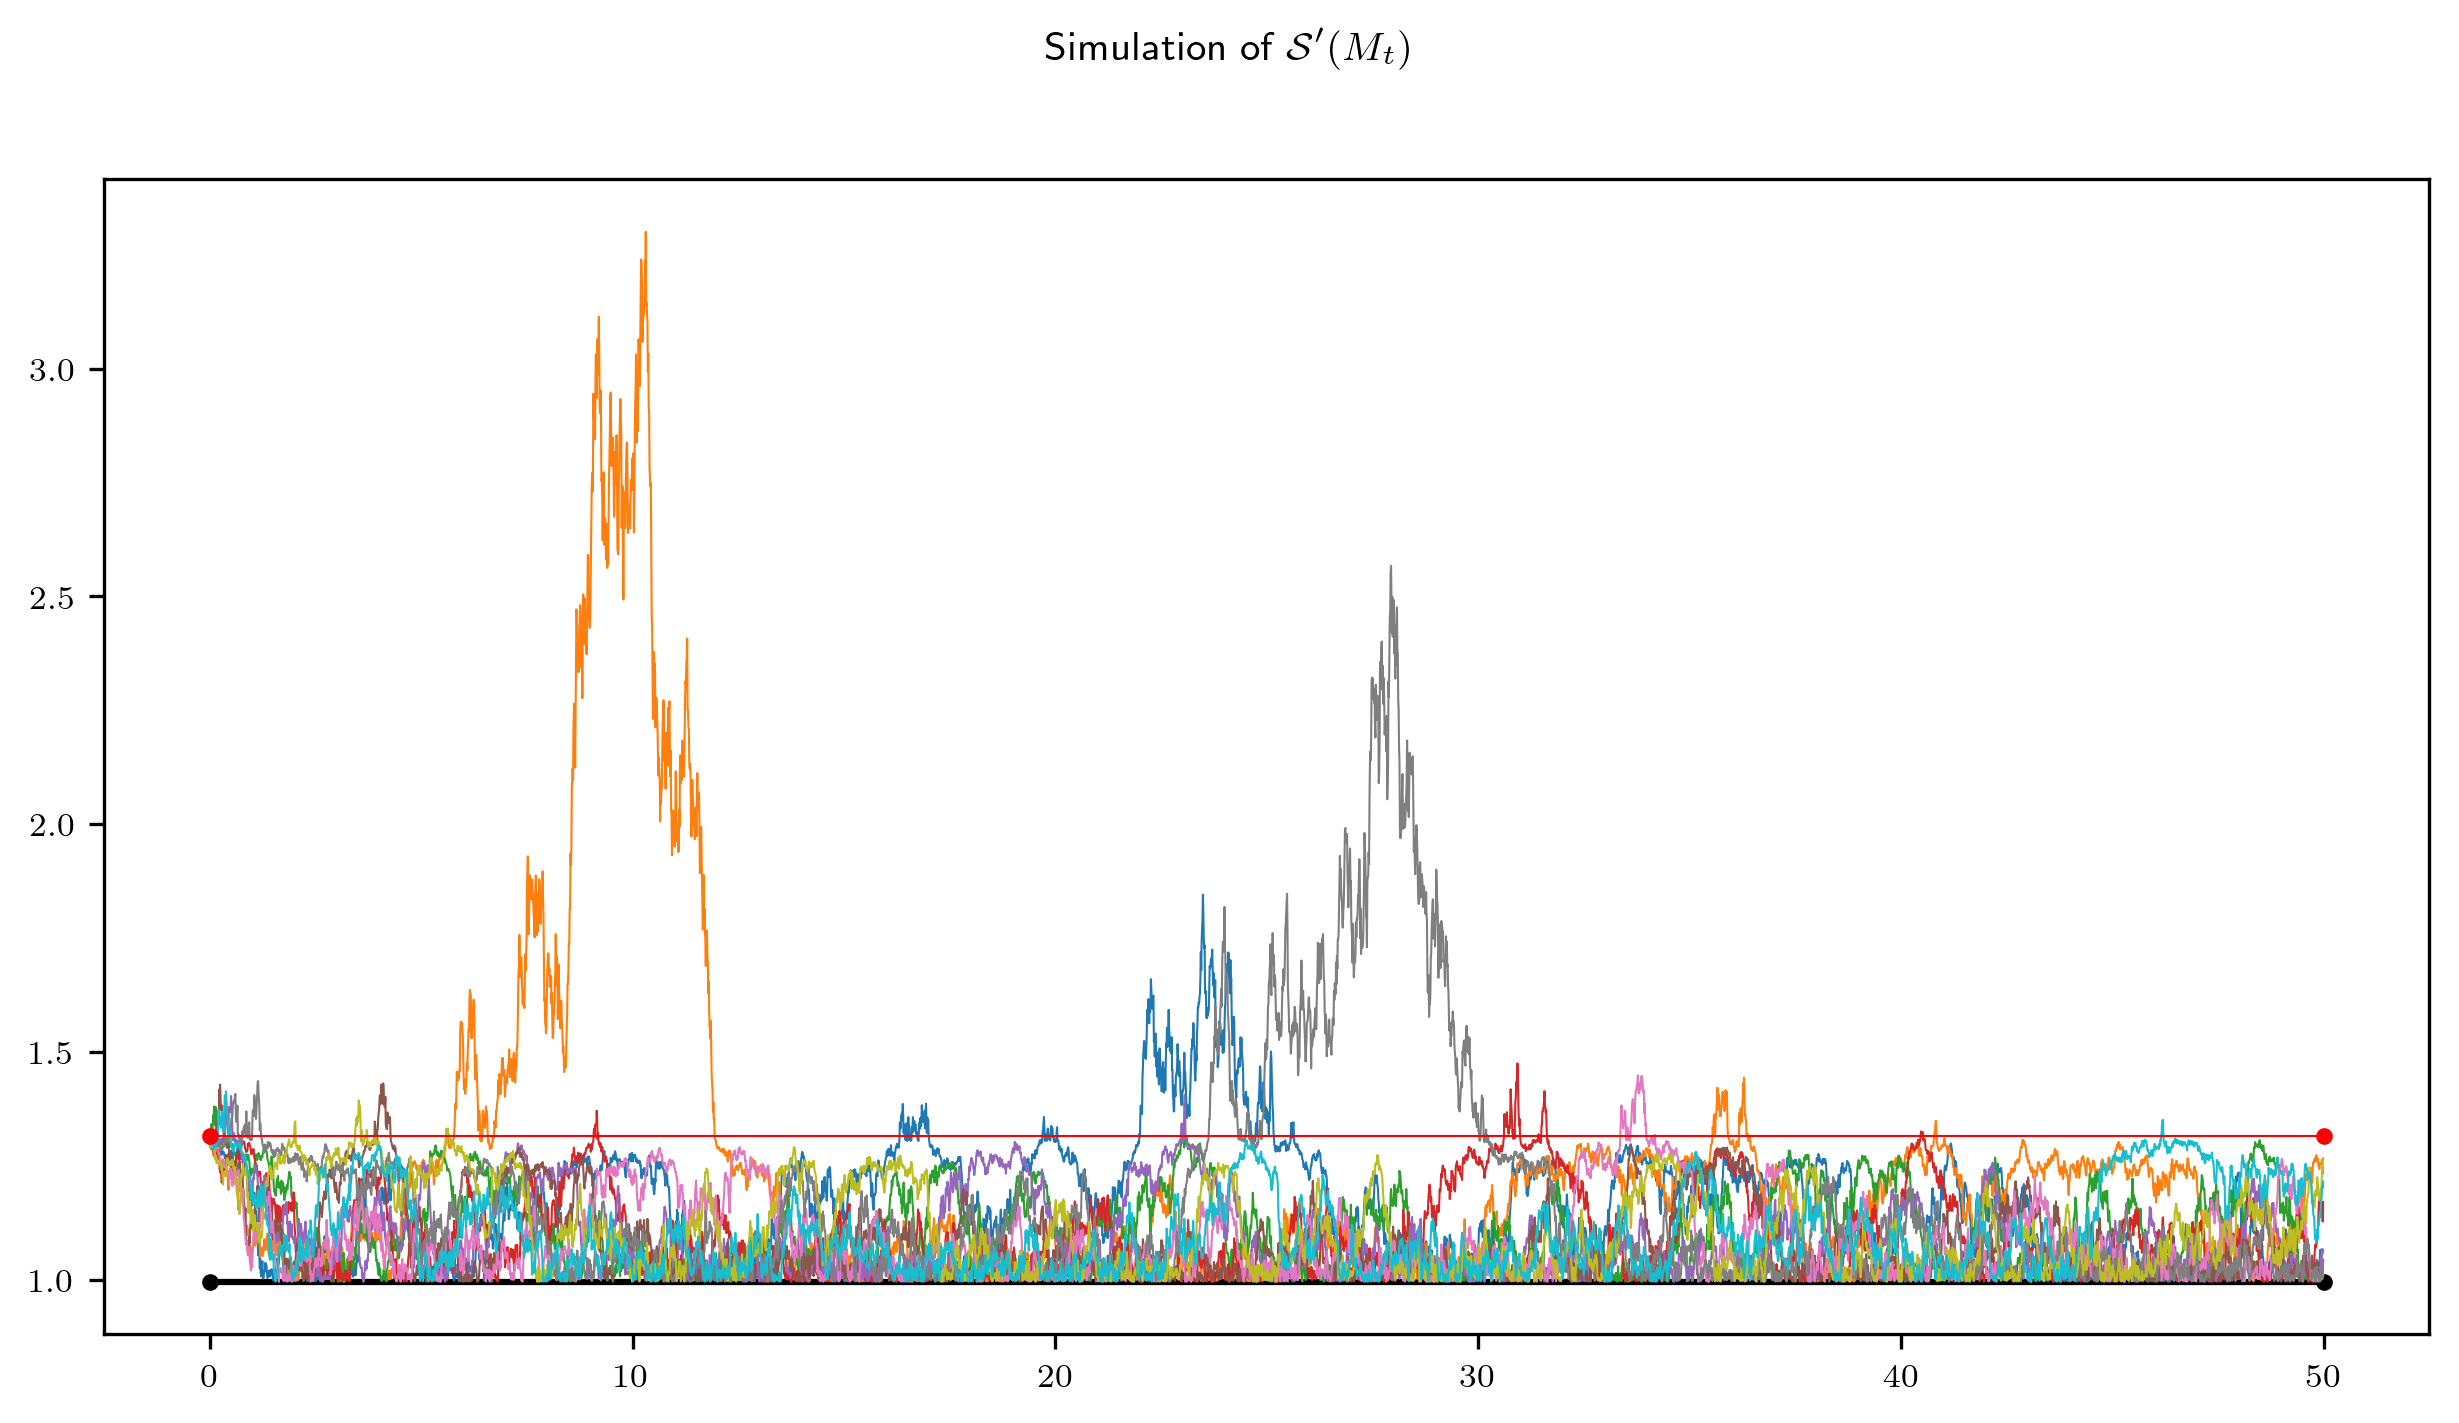

In [116]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot([0,T],[SOL.solution_S.sol(m_p)[1]]*2,'k.-')
plt.plot(np.arange(0,T,T/N),np.transpose(Sp[np.random.randint(0,1000,(10)),:]),linewidth=0.5 )
for s in swtch:
    plt.plot([0,T],[SOL.solution_S.sol(s)[1]]*2,'r.-', linewidth=0.5)    
f.suptitle(r'Simulation of $\mathcal{S}^\prime(M_t)$');
# plt.tight_layout();    


In [117]:
Markdown(r'The volatility as a function of cash reserve  is goven by $\mathcal{V}(s):= \dfrac{\mathcal{S}^{\prime}( m )  \sigma({\lambda}m)}{\mathcal{S}(m)}$')

The volatility as a function of cash reserve  is goven by $\mathcal{V}(s):= \dfrac{\mathcal{S}^{\prime}( m )  \sigma({\lambda}m)}{\mathcal{S}(m)}$

# Optimal $\sigma^*(\lambda m)$

In [118]:
sigma = np.zeros(M.shape)
for i in range(M.shape[0]):
    sigma[i,:] = SOL.optimal(lb*M[i,:])[0]

In [119]:
Vol = Sp*sigma/S
def vol(m):
    return SOL.optimal([SOL.param[3]*m])[0]*SOL.solution_S.sol(m)[1]/SOL.solution_S.sol(m)[0]

In [120]:
Markdown(r'The volatility as a function of asset price is goven by $\mathcal{V}(s):= \dfrac{\mathcal{S}^{\prime}( \mathcal{S}^{-1} (s) )  \sigma({\lambda}\mathcal{S}^{-1} (s))}{s}$')

The volatility as a function of asset price is goven by $\mathcal{V}(s):= \dfrac{\mathcal{S}^{\prime}( \mathcal{S}^{-1} (s) )  \sigma({\lambda}\mathcal{S}^{-1} (s))}{s}$

In [121]:
m_p, vol(m_p)


(0.887943971985993, array([0.1221442]))

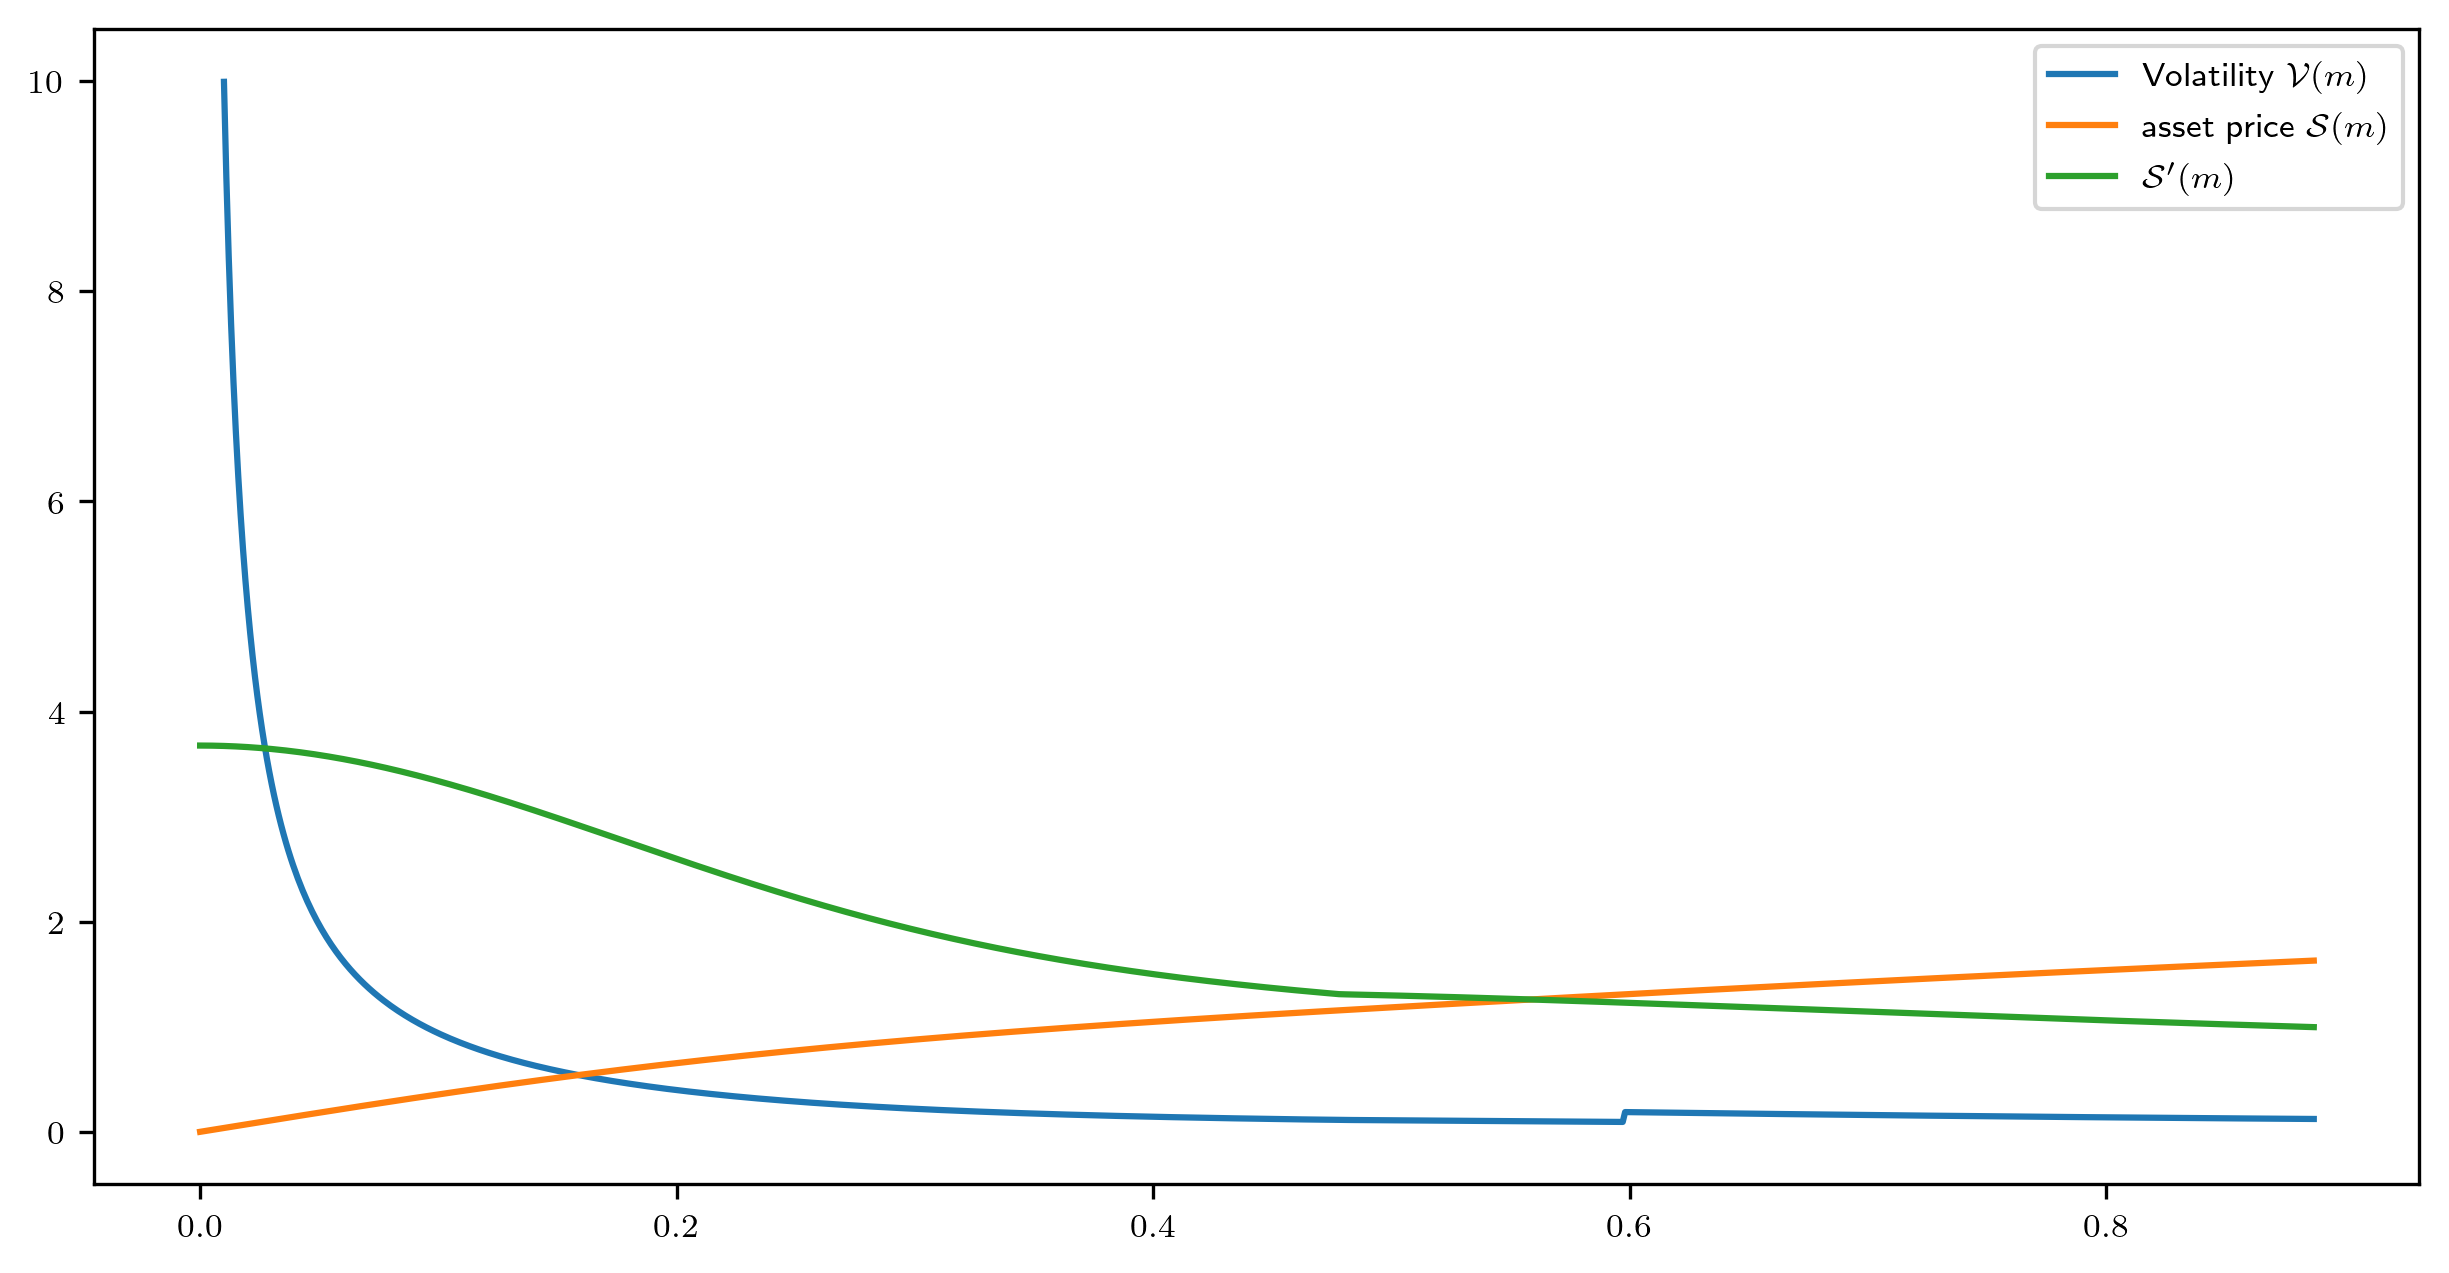

In [122]:
f = plt.figure(figsize=(10,5), dpi=300)
m_ = np.arange(0.01,m_p,0.001)
m = np.arange(0,m_p,0.001)
vol_m = [vol(x) for x in m_]
plt.plot(m_ ,vol_m,label='Volatility $\mathcal{V}(m)$')
plt.plot(m ,SOL.solution_S.sol(m)[0],label=r'asset price $\mathcal{S}(m)$')
plt.plot(m ,SOL.solution_S.sol(m)[1],label=r'$\mathcal{S}^\prime(m)$')
plt.legend();

In [123]:
for s in swtch:
    print(s,vol(s))   

0.4752376188094047 [0.11414506]


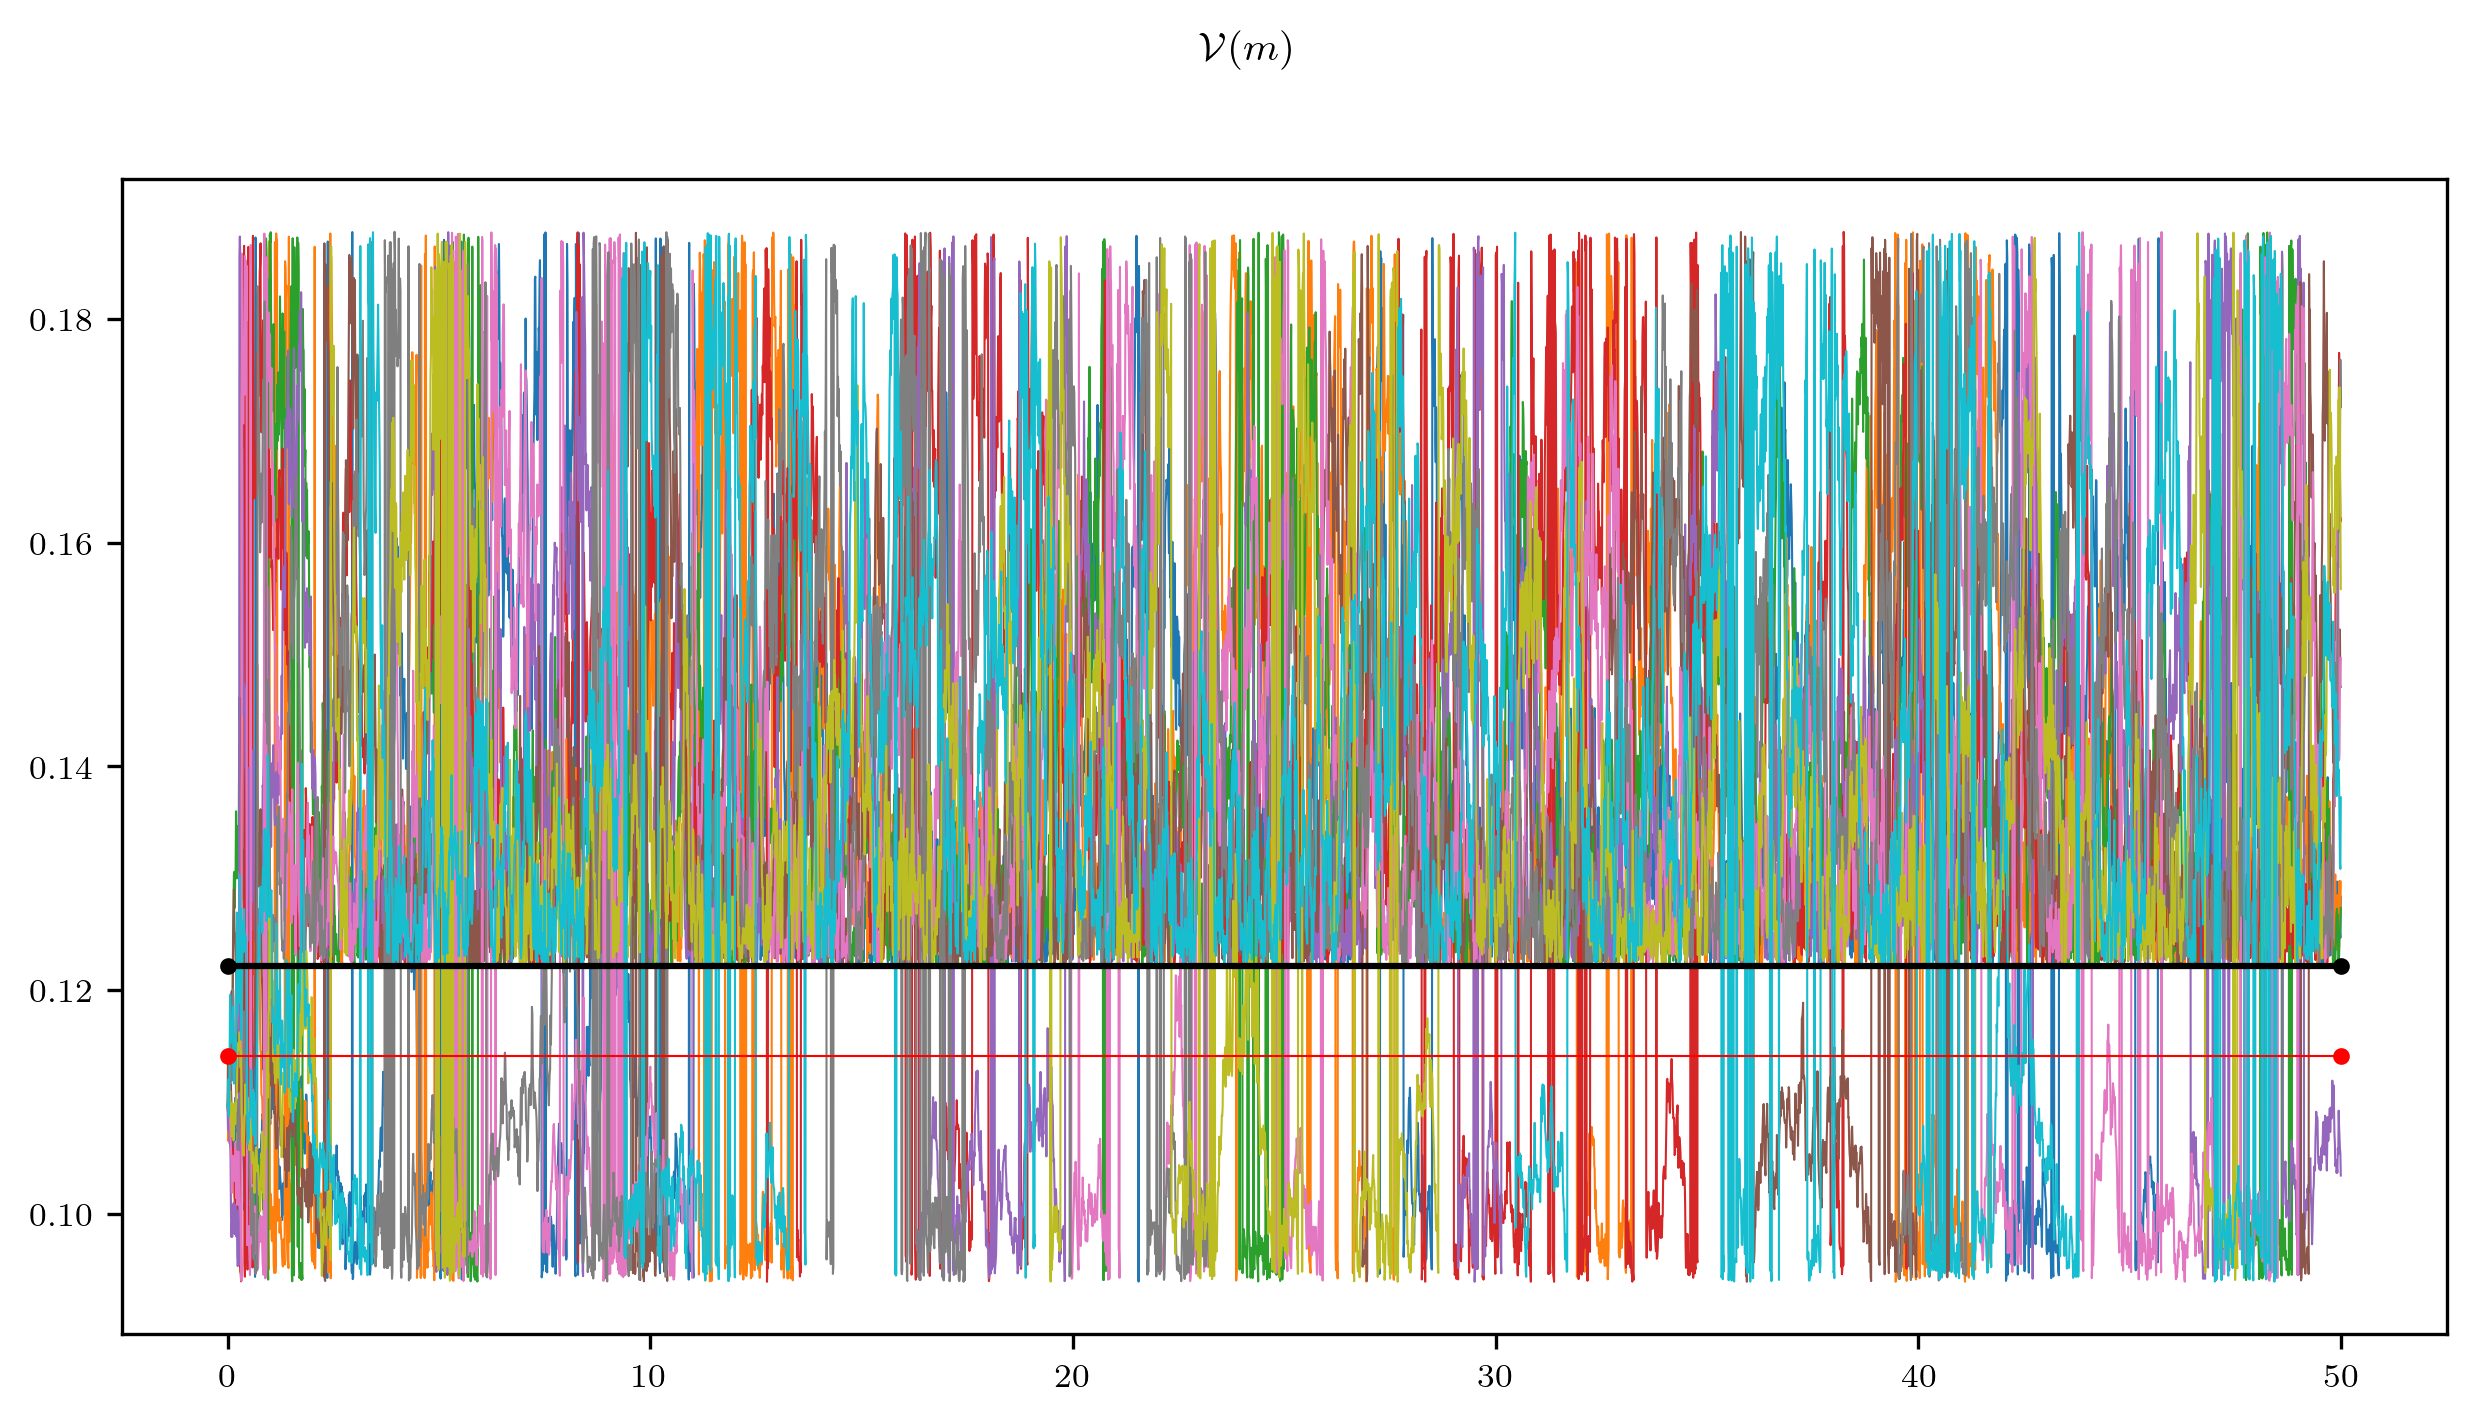

In [124]:
f = plt.figure(figsize=(10,5), dpi=300)
# Vol_ = np.minimum(Vol,2)
plt.plot(np.arange(0,T,T/N),np.transpose(Vol[np.random.randint(0,1000,(10)),:]),linewidth=0.5);
plt.plot([0,T],[vol(m_p)]*2,'k.-')
for s in swtch:
    plt.plot([0,T],[vol(s)]*2,'r.-', linewidth=0.5)   
f.suptitle(r'$\mathcal{V}(m)$');    

In [125]:
I = []
for i in range(M.shape[0]):
    if M[i,:].all()!=0:
        I.append(i)
len(I)       
M[I,:].shape

(9958, 5000)

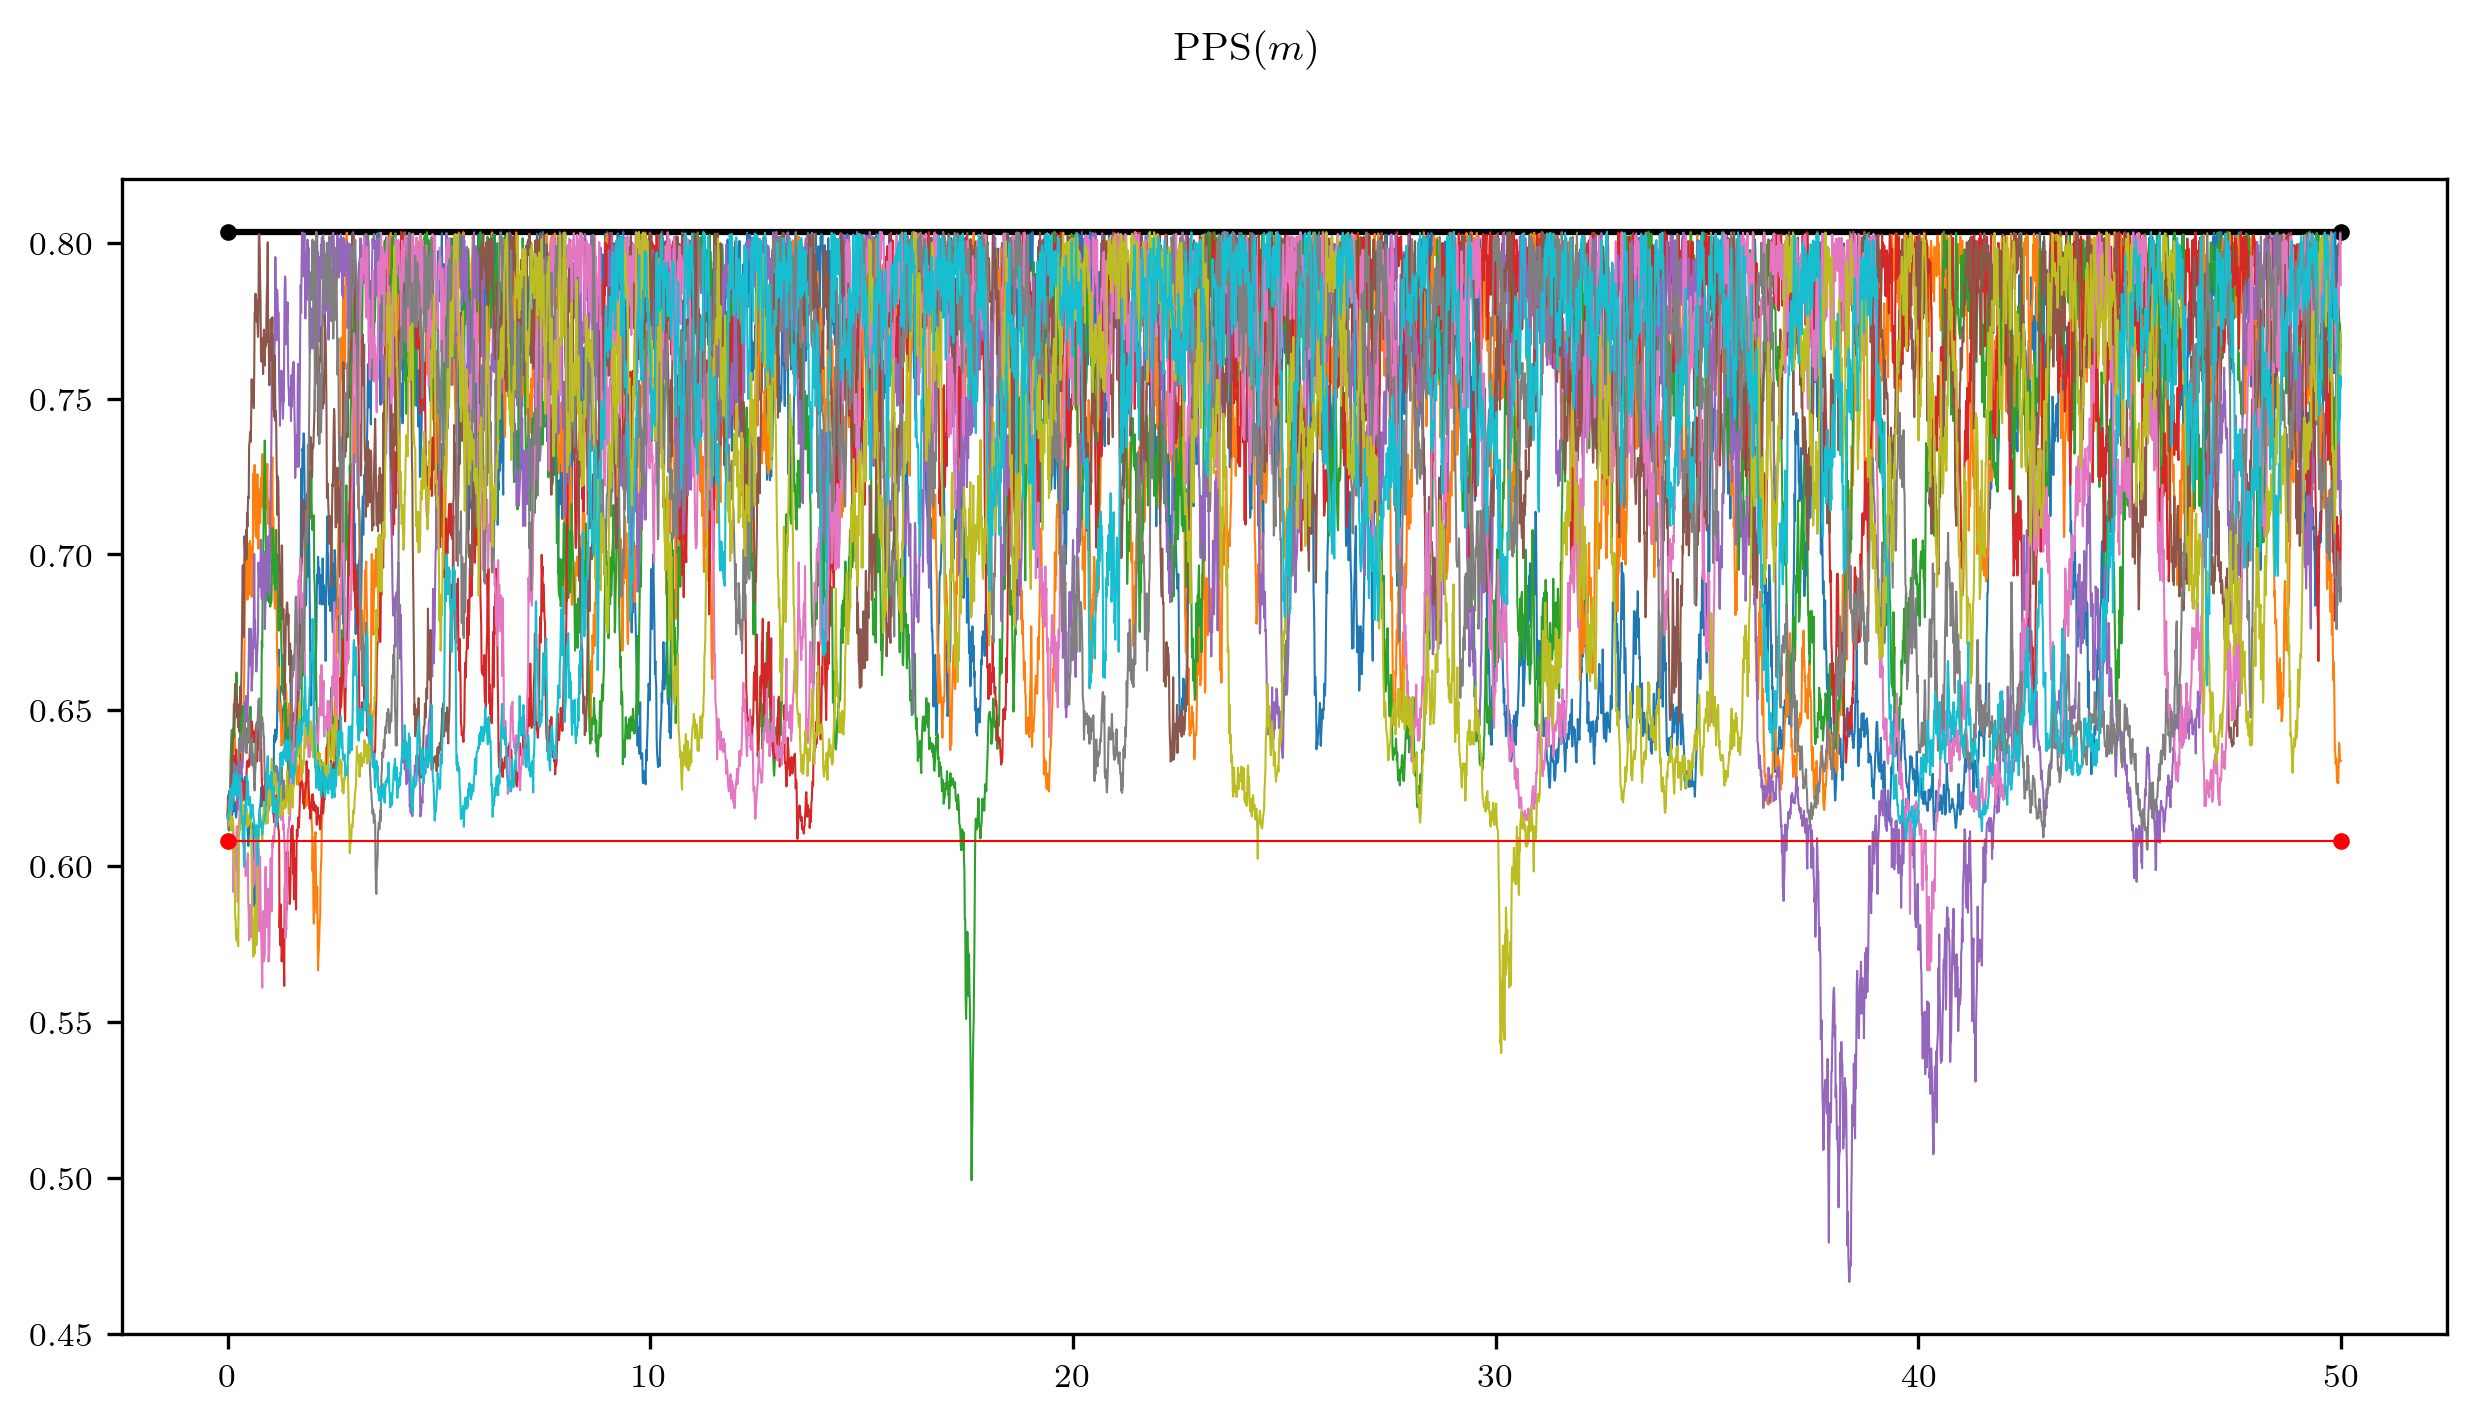

In [126]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot([0,T],[lb/SOL.solution_S.sol(m_p)[1]]*2,'k.-')
plt.plot(np.arange(0,T,T/N),np.transpose(PPS[np.random.randint(0,1000,(10)),:]),linewidth=0.5 );
for s in swtch:
    plt.plot([0,T],[lb/SOL.solution_S.sol(s)[1]]*2,'r.-', linewidth=0.5)    
f.suptitle(r'$\textrm{PPS}(m)$');    

In [127]:
Markdown(r'The PPS as a function of cash reserve  is goven by $\textrm{PPS}(m):=\dfrac{\lambda\sigma(\lambda m)}{\mathcal{V}( m )  S(m)}=\dfrac{\lambda}{\mathcal{S}^{\prime}( m )}$')

The PPS as a function of cash reserve  is goven by $\textrm{PPS}(m):=\dfrac{\lambda\sigma(\lambda m)}{\mathcal{V}( m )  S(m)}=\dfrac{\lambda}{\mathcal{S}^{\prime}( m )}$

# Covariences

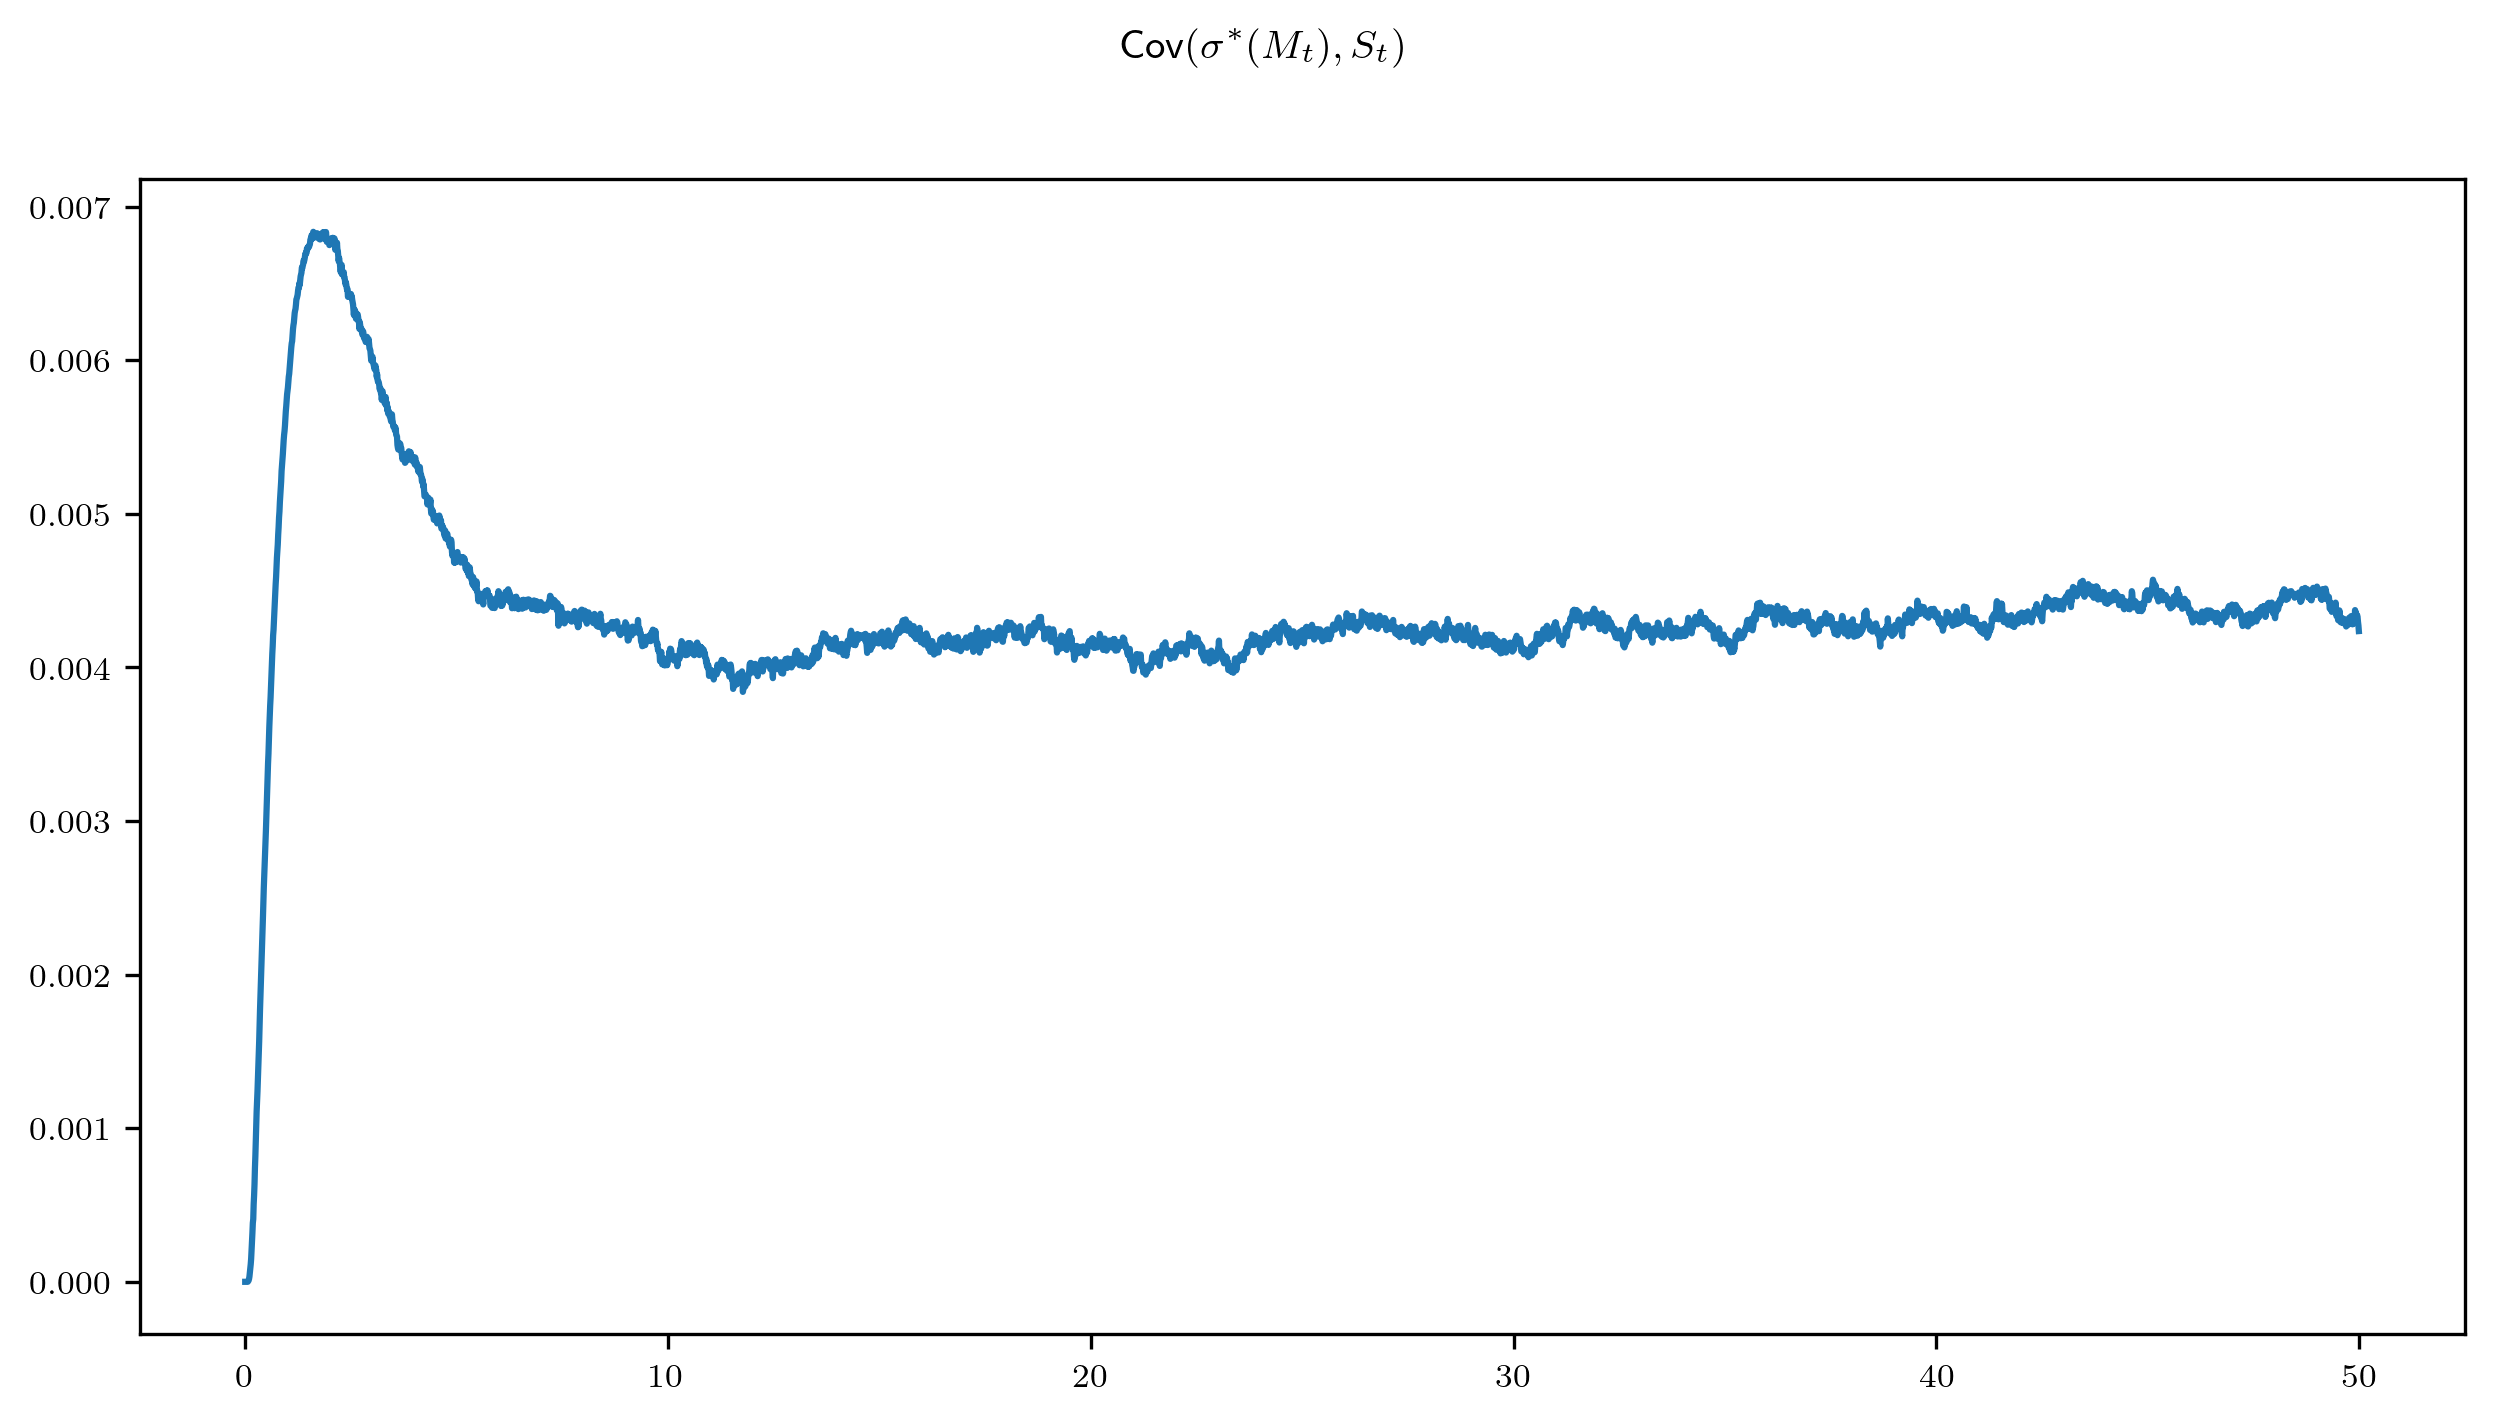

In [128]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),(sigma*S).mean(axis=0)-sigma.mean(axis=0)*S.mean(axis=0),linewidth=1.5);
f.suptitle(r'Cov$(\sigma^*(M_t),S_t)$');

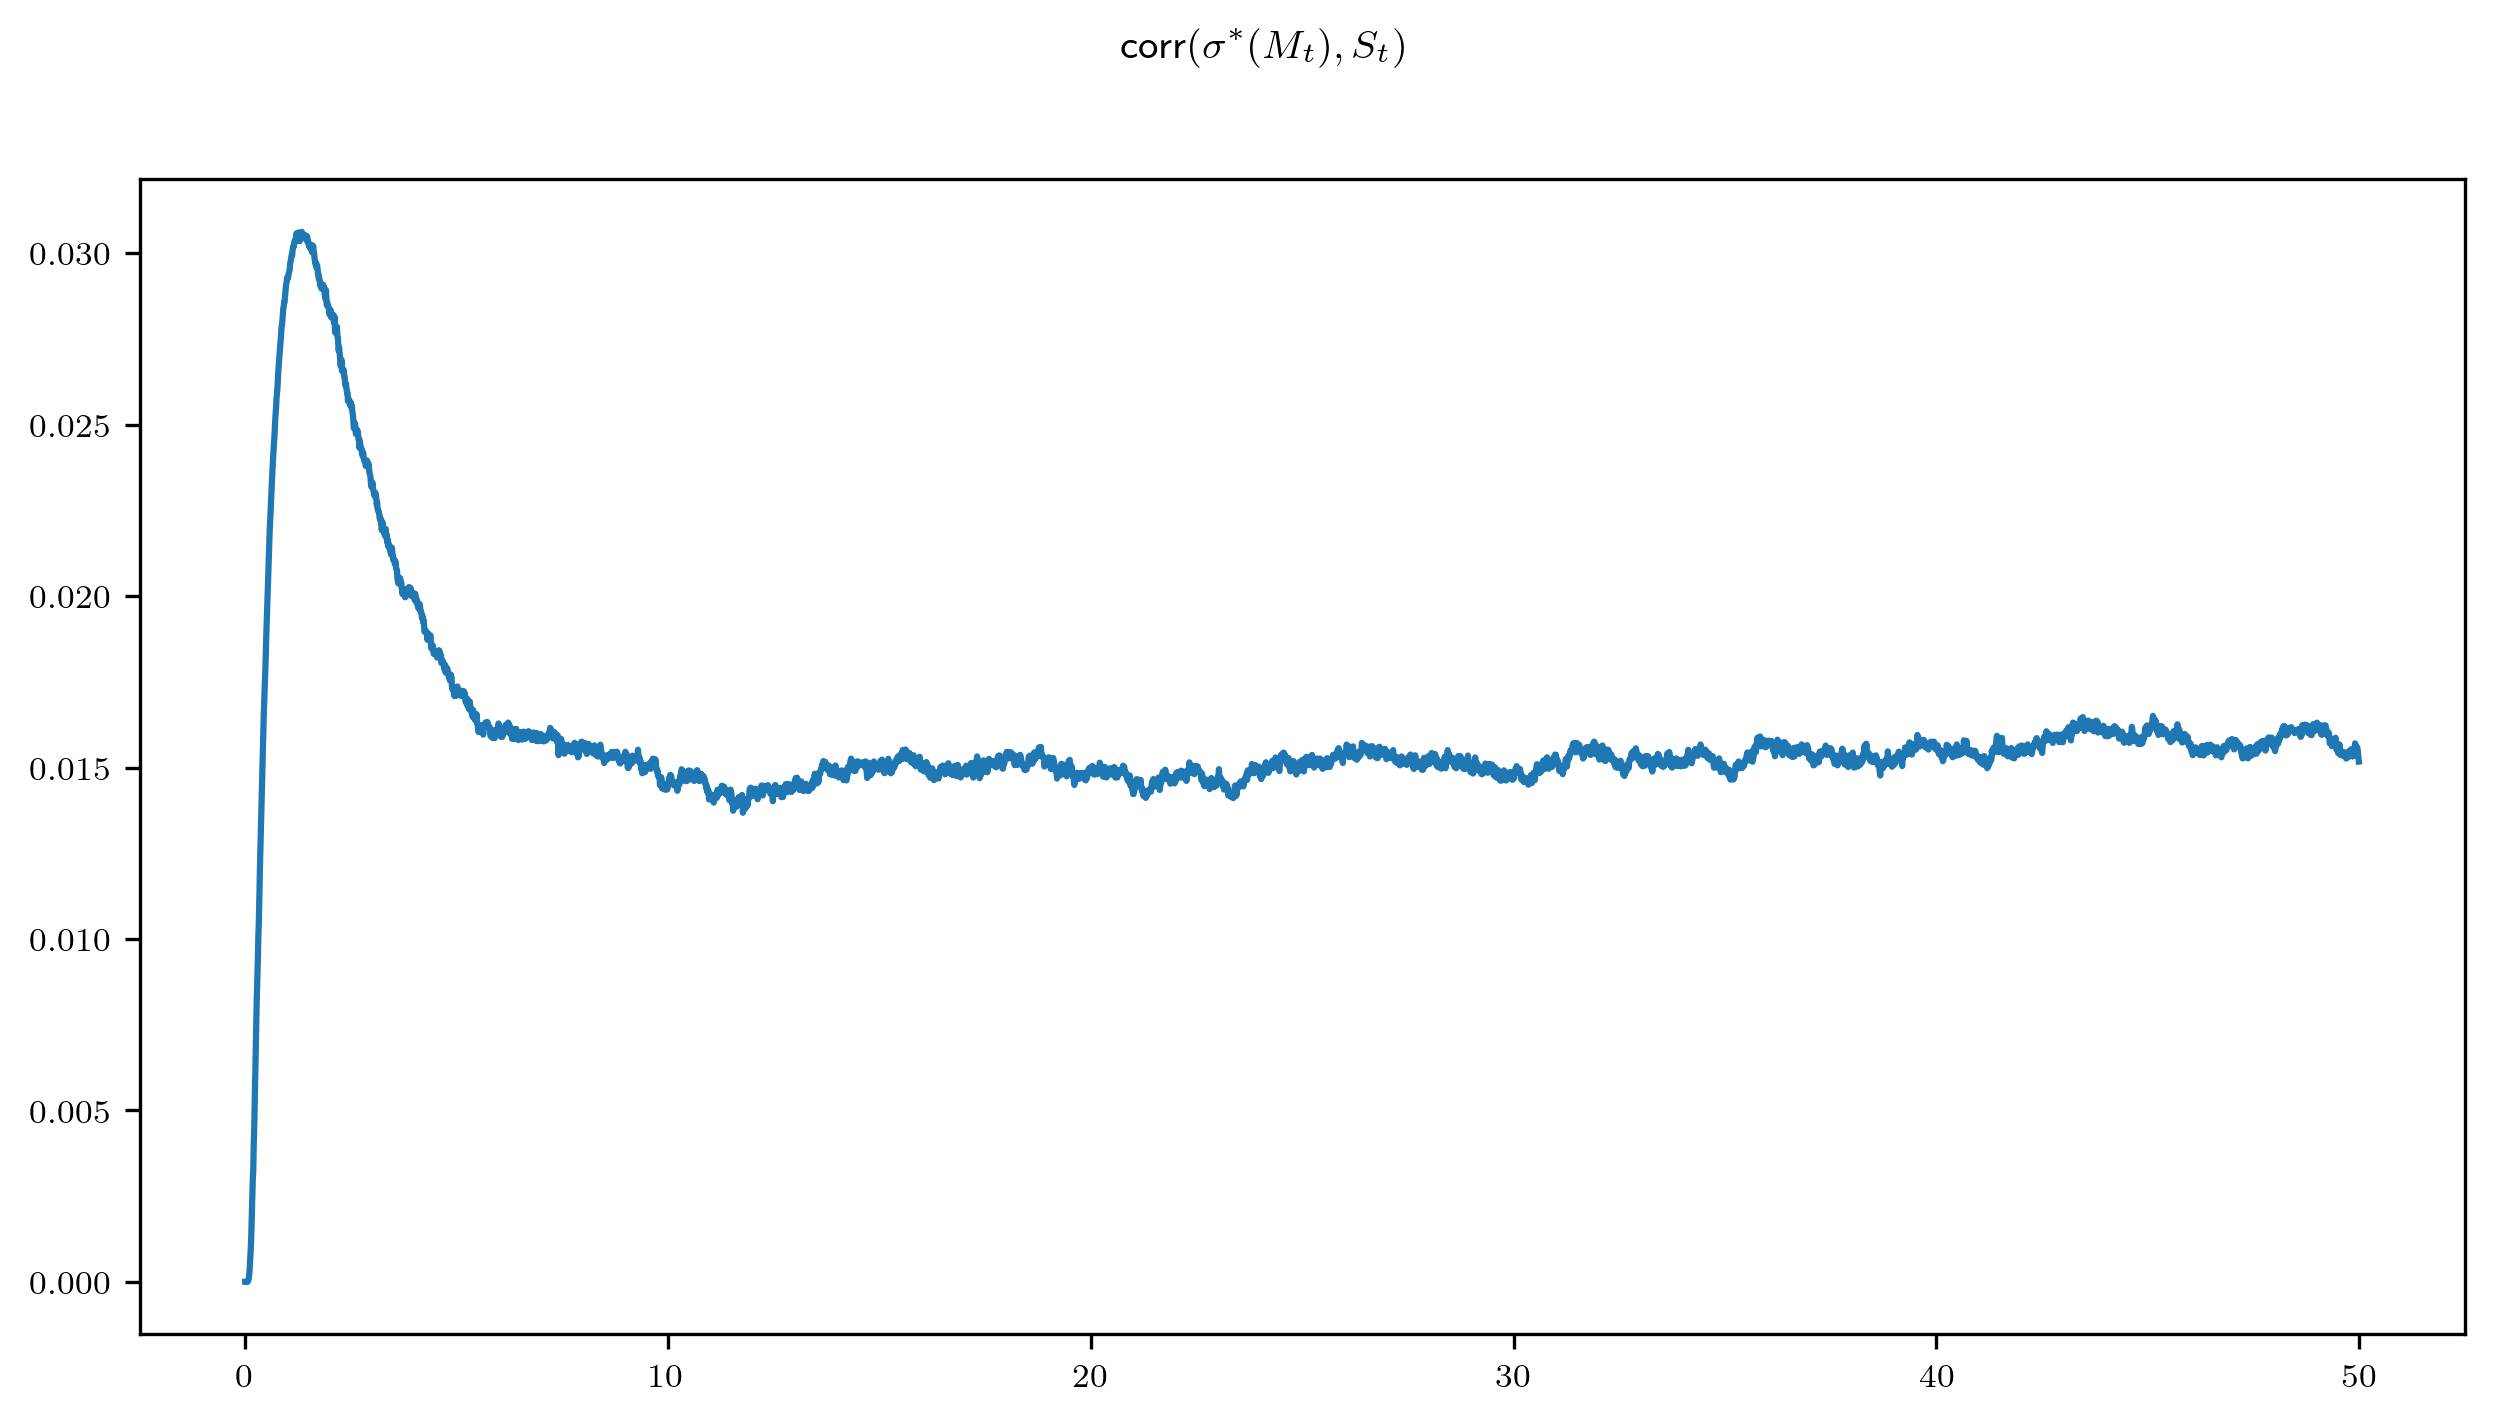

In [129]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((sigma*S).mean(axis=0)-sigma.mean(axis=0)*S.mean(axis=0))/(np.sqrt((sigma*sigma).mean(axis=0))*np.sqrt((S*S).mean(axis=0))),linewidth=1.5);
f.suptitle(r'corr$(\sigma^*(M_t),S_t)$');

In [130]:
Vol[I,:]

array([[0.10951952, 0.11099028, 0.1108623 , ..., 0.17740431, 0.17727036,
        0.17612508],
       [0.10951952, 0.1117526 , 0.11043611, ..., 0.16749949, 0.16459308,
        0.16930294],
       [0.10951952, 0.11074057, 0.11227352, ..., 0.12216695, 0.12634107,
        0.12215257],
       ...,
       [0.10951952, 0.11063136, 0.10948848, ..., 0.13252204, 0.13125246,
        0.12585222],
       [0.10951952, 0.1076275 , 0.10712821, ..., 0.12344055, 0.12398176,
        0.12515965],
       [0.10951952, 0.10981912, 0.10992486, ..., 0.16456292, 0.16171454,
        0.16152534]])

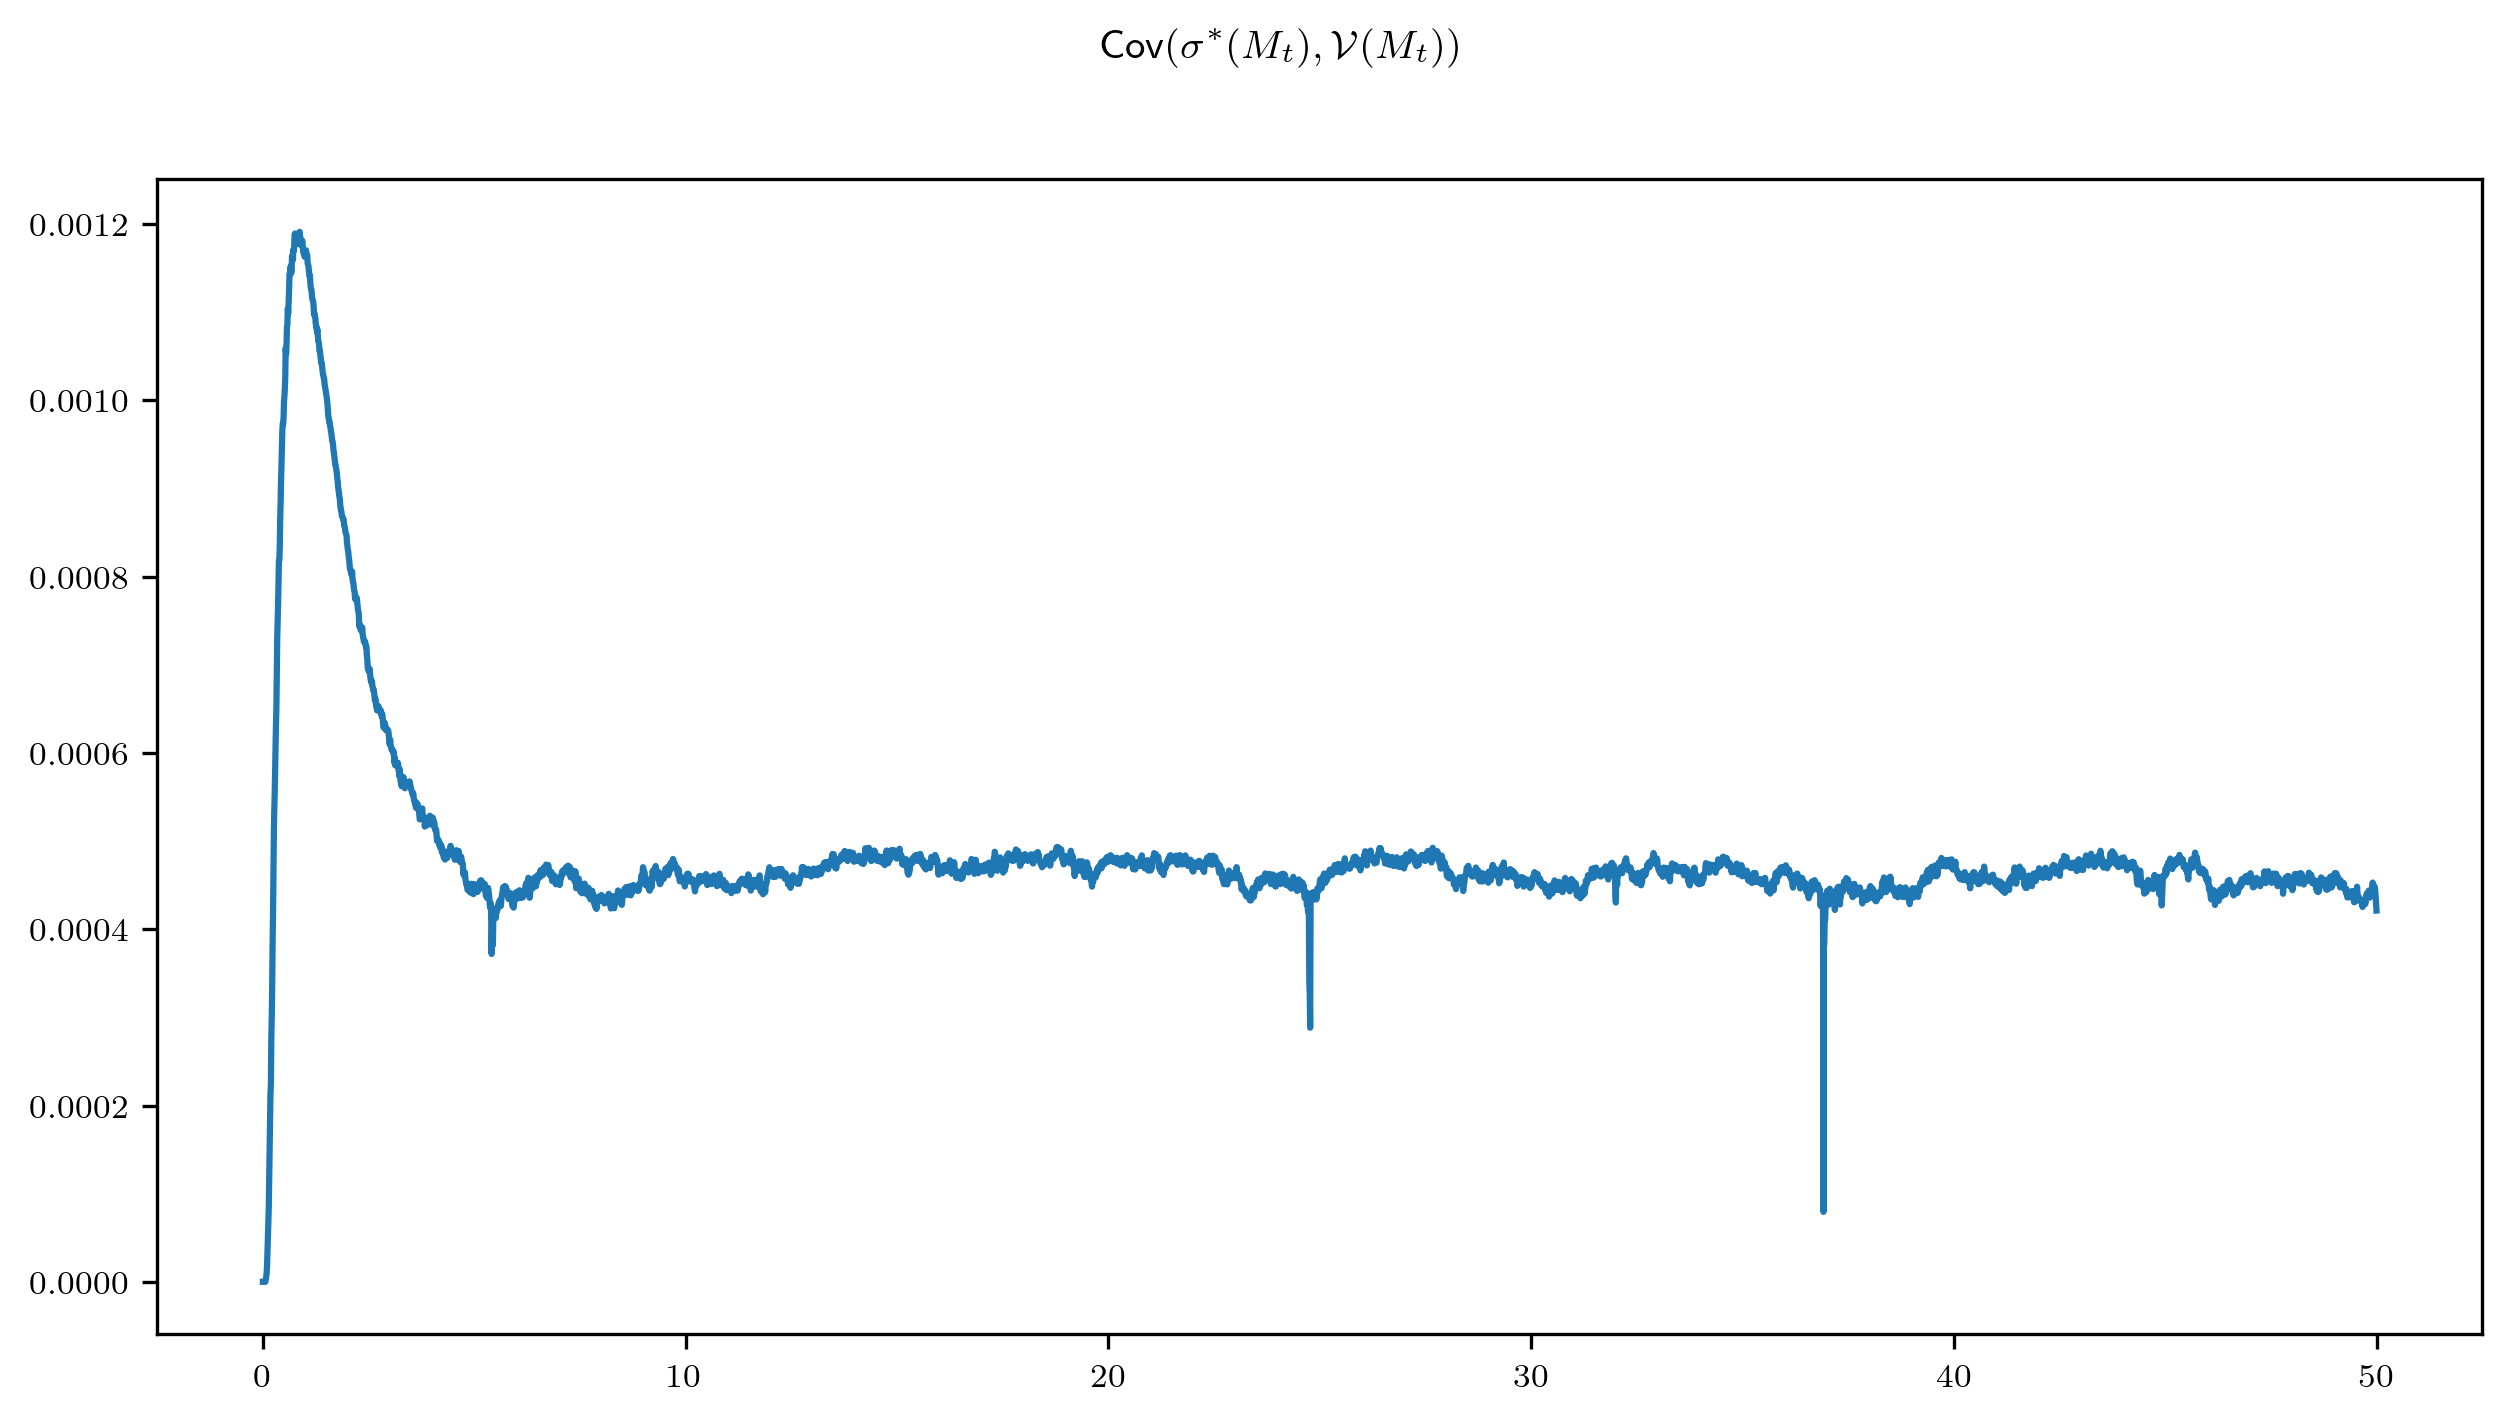

In [131]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((sigma[I,:]*Vol[I,:]).mean(axis=0)-sigma[I,:].mean(axis=0)*Vol[I,:].mean(axis=0)),linewidth=1.5);

# Y = np.zeros(X.shape)
# sigma = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     sigma[i,:] = SOL.optimal(np.array([SOL.param[3]]*X[i,:]))[0]
#     Y[i,:] = vol(X[i,:])*sigma[i,:]
# sigma_var = np.sqrt((sigma*sigma).sum(axis=0))    
# Xvar = np.sqrt((X*X).sum(axis=0))
# plt.plot(np.arange(0,T,T/N),(Y.mean(axis=0)-sigma.mean(axis=0)*X.mean(axis=0))/(Xvar*sigma_var),linewidth=1.5);
f.suptitle(r'Cov$(\sigma^*(M_t),\mathcal{V}(M_t))$');

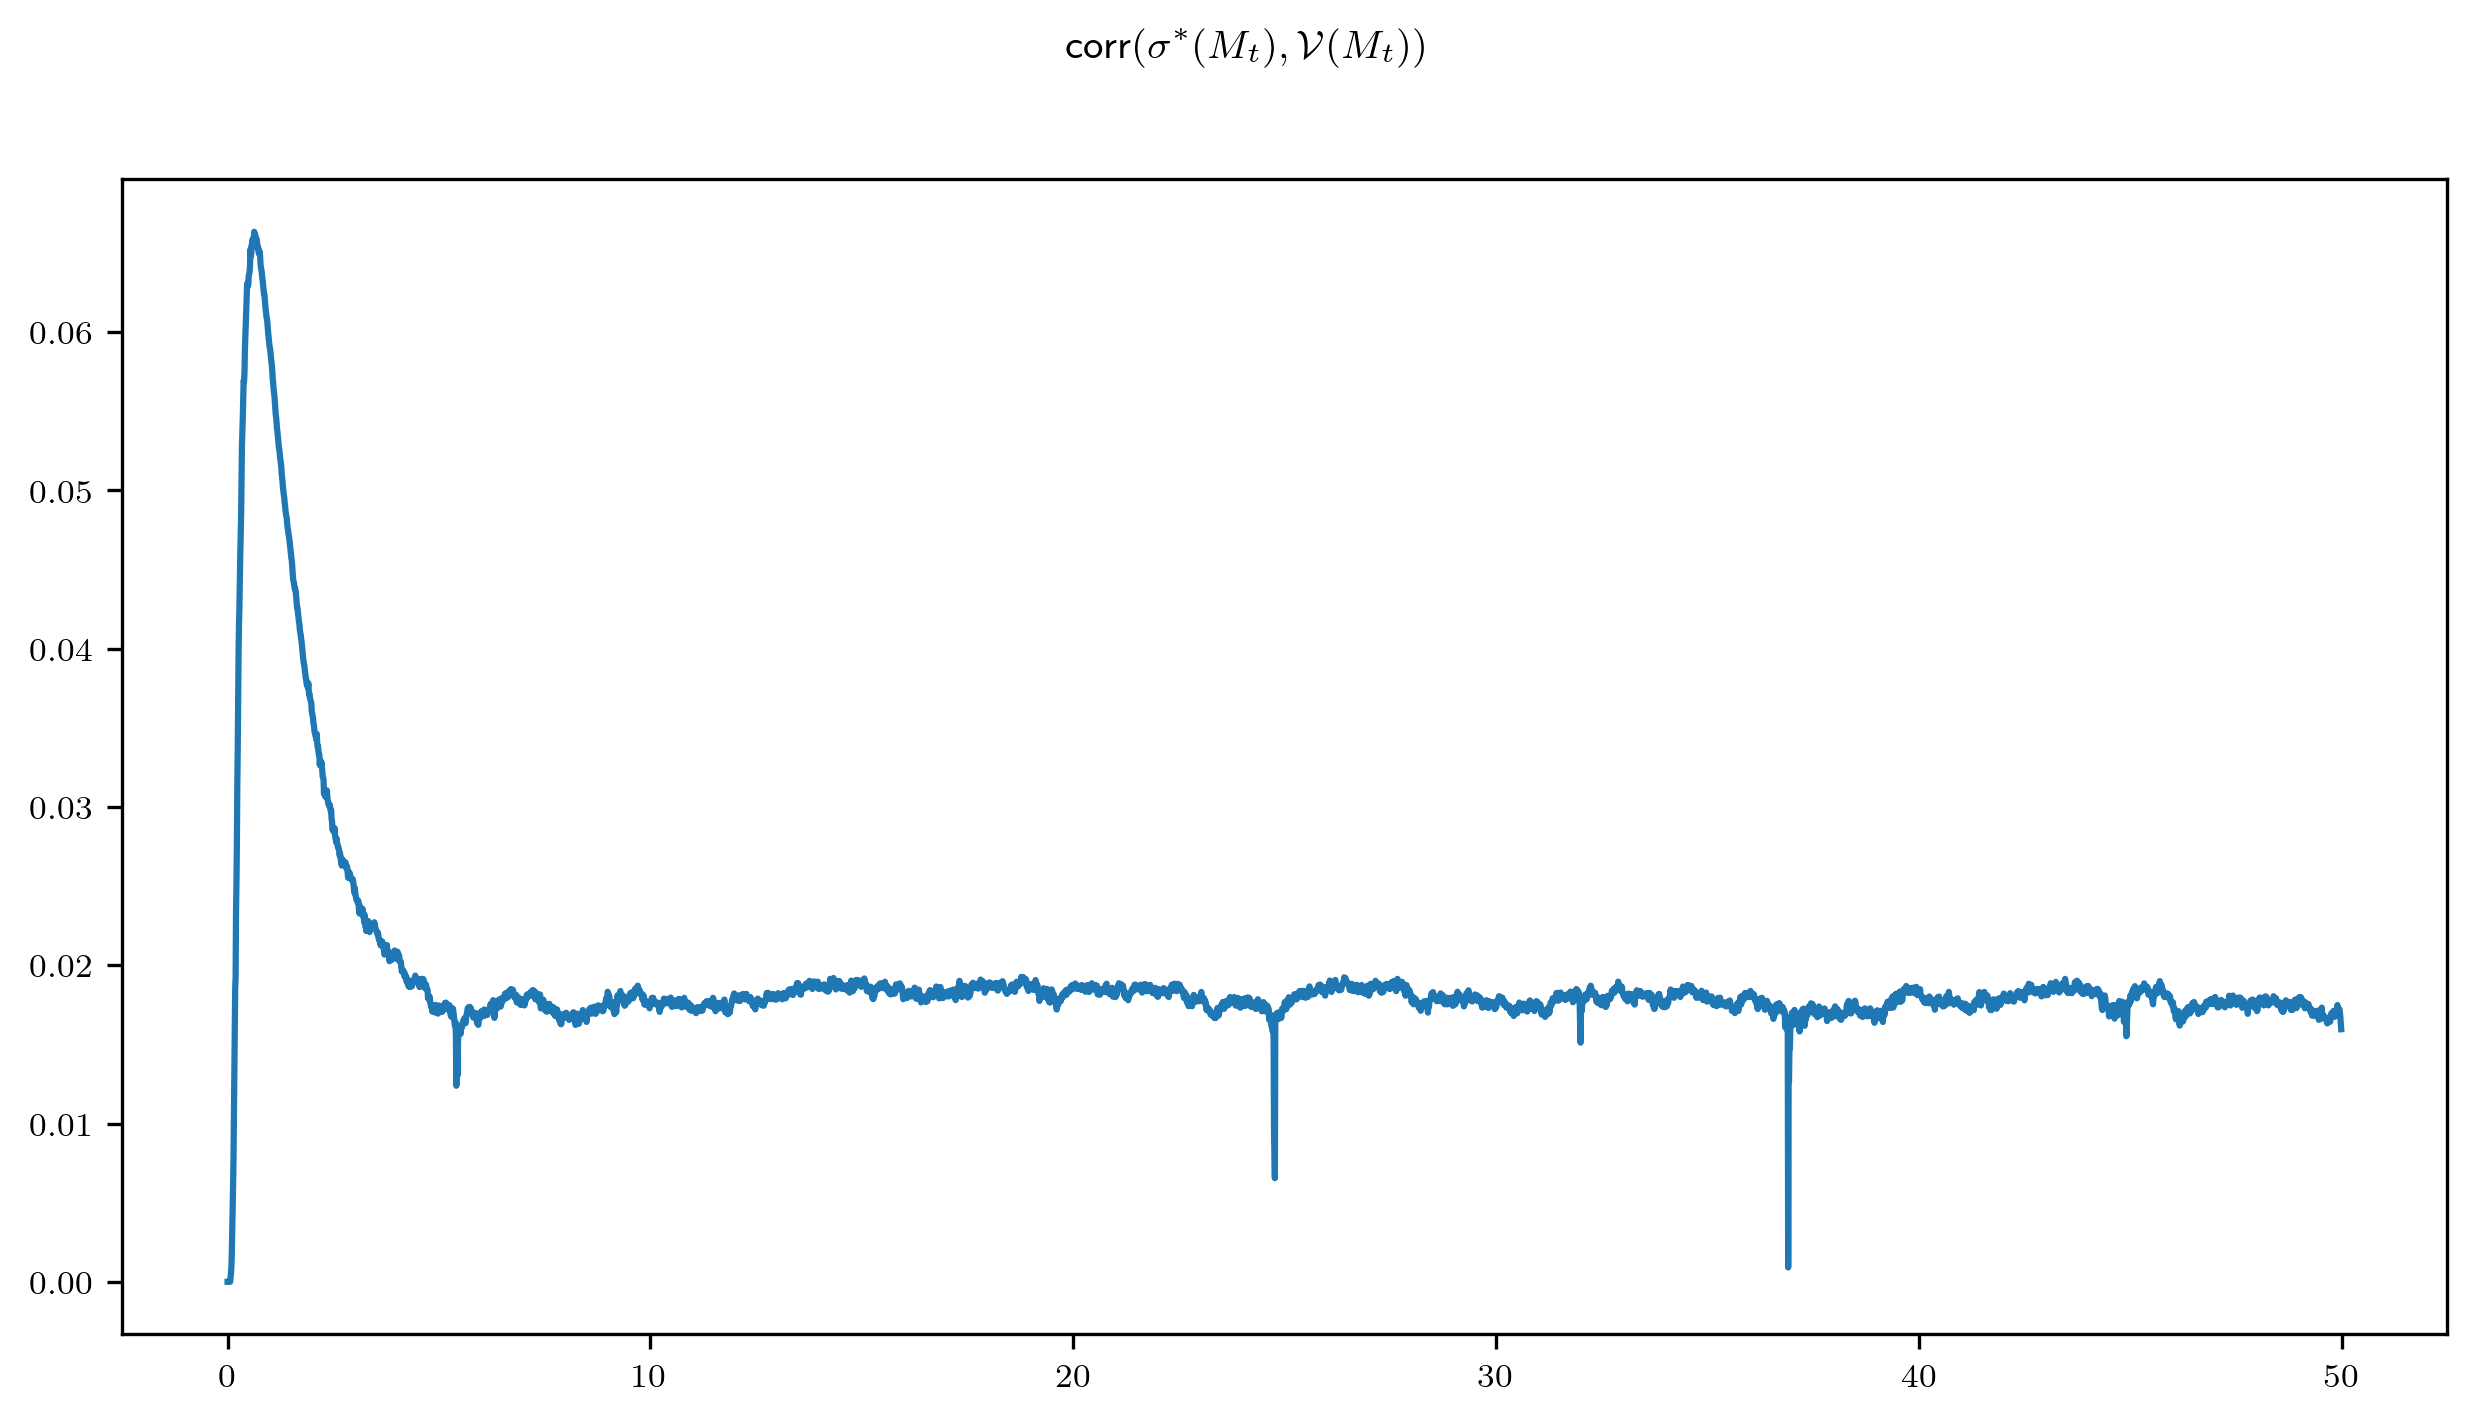

In [132]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((sigma[I,:]*Vol[I,:]).mean(axis=0)-sigma[I,:].mean(axis=0)*Vol[I,:].mean(axis=0))/(np.sqrt((sigma[I,:]*sigma[I,:]).mean(axis=0))*np.sqrt((Vol[I,:]*Vol[I,:]).mean(axis=0))),linewidth=1.5);
f.suptitle(r'corr$(\sigma^*(M_t),\mathcal{V}(M_t))$');

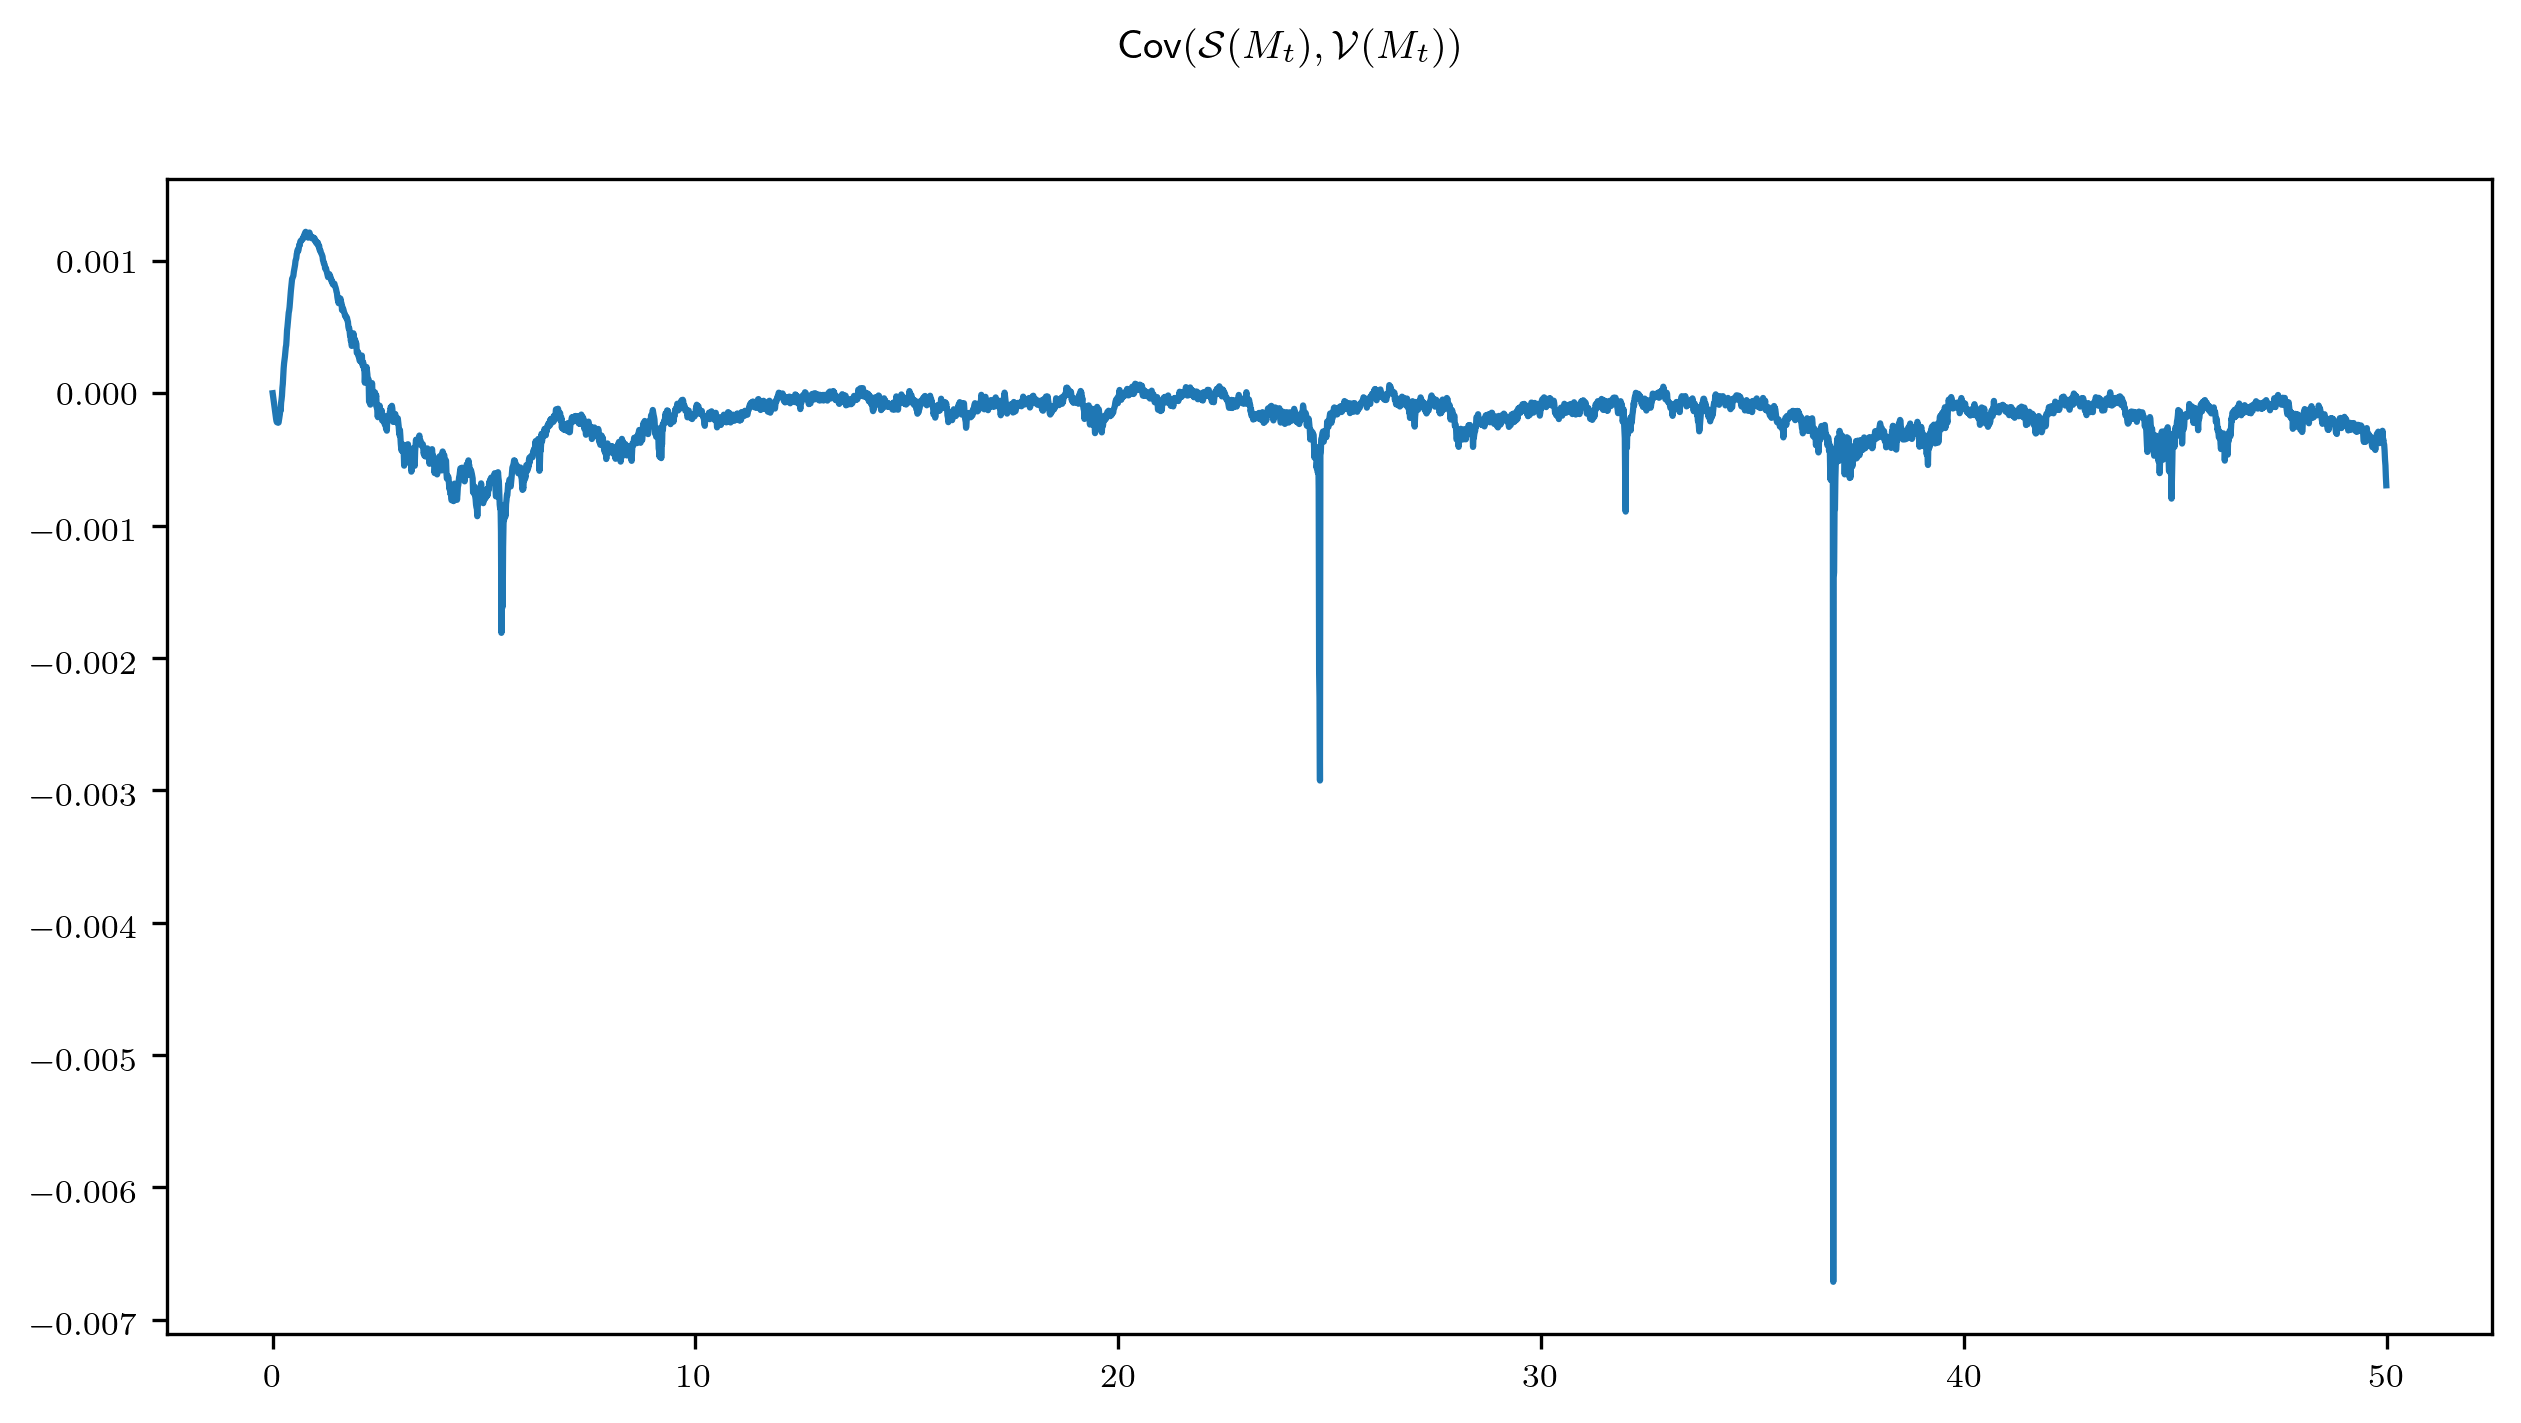

In [133]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((Vol[I,:]*S[I,:]).mean(axis=0)-Vol[I,:].mean(axis=0)*S[I,:].mean(axis=0)),linewidth=1.5);
f.suptitle(r'Cov$(\mathcal{S}(M_t),\mathcal{V}(M_t))$');

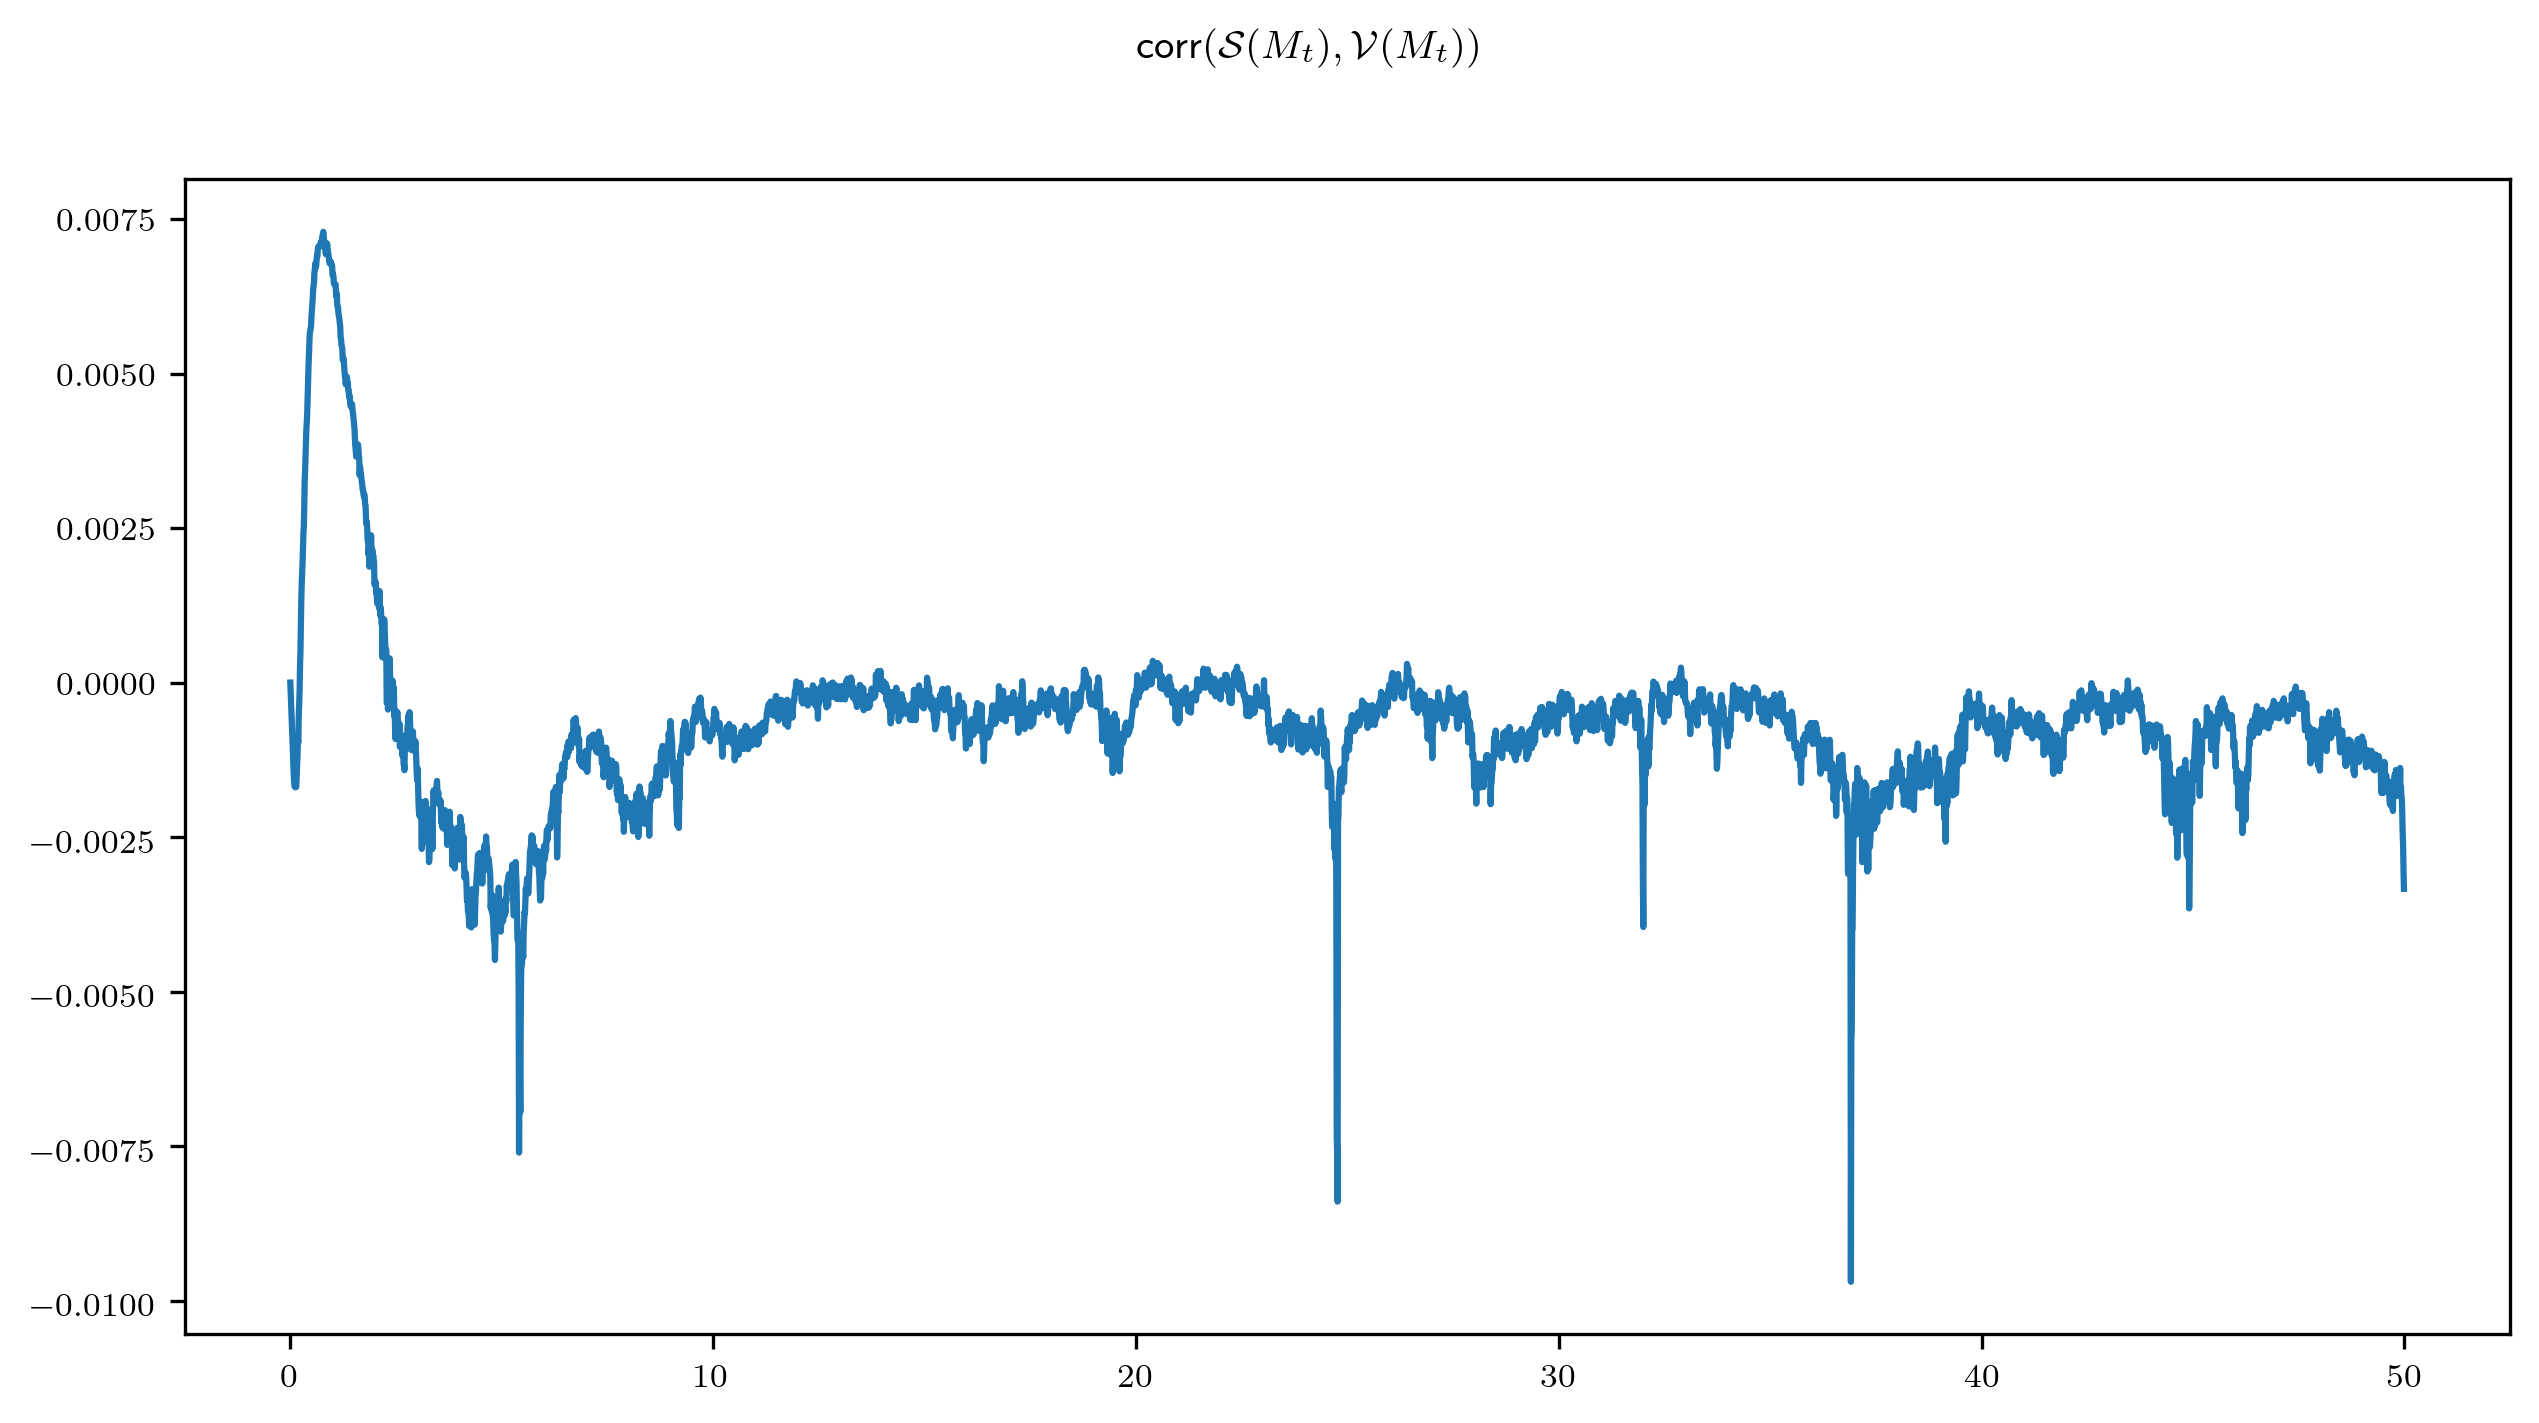

In [134]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((Vol[I,:]*S[I,:]).mean(axis=0)-Vol[I,:].mean(axis=0)*S[I,:].mean(axis=0))/(np.sqrt((Vol[I,:]*Vol[I,:]).mean(axis=0))*np.sqrt((S[I,:]*S[I,:]).mean(axis=0))),linewidth=1.5);
f.suptitle(r'corr$(\mathcal{S}(M_t),\mathcal{V}(M_t))$');

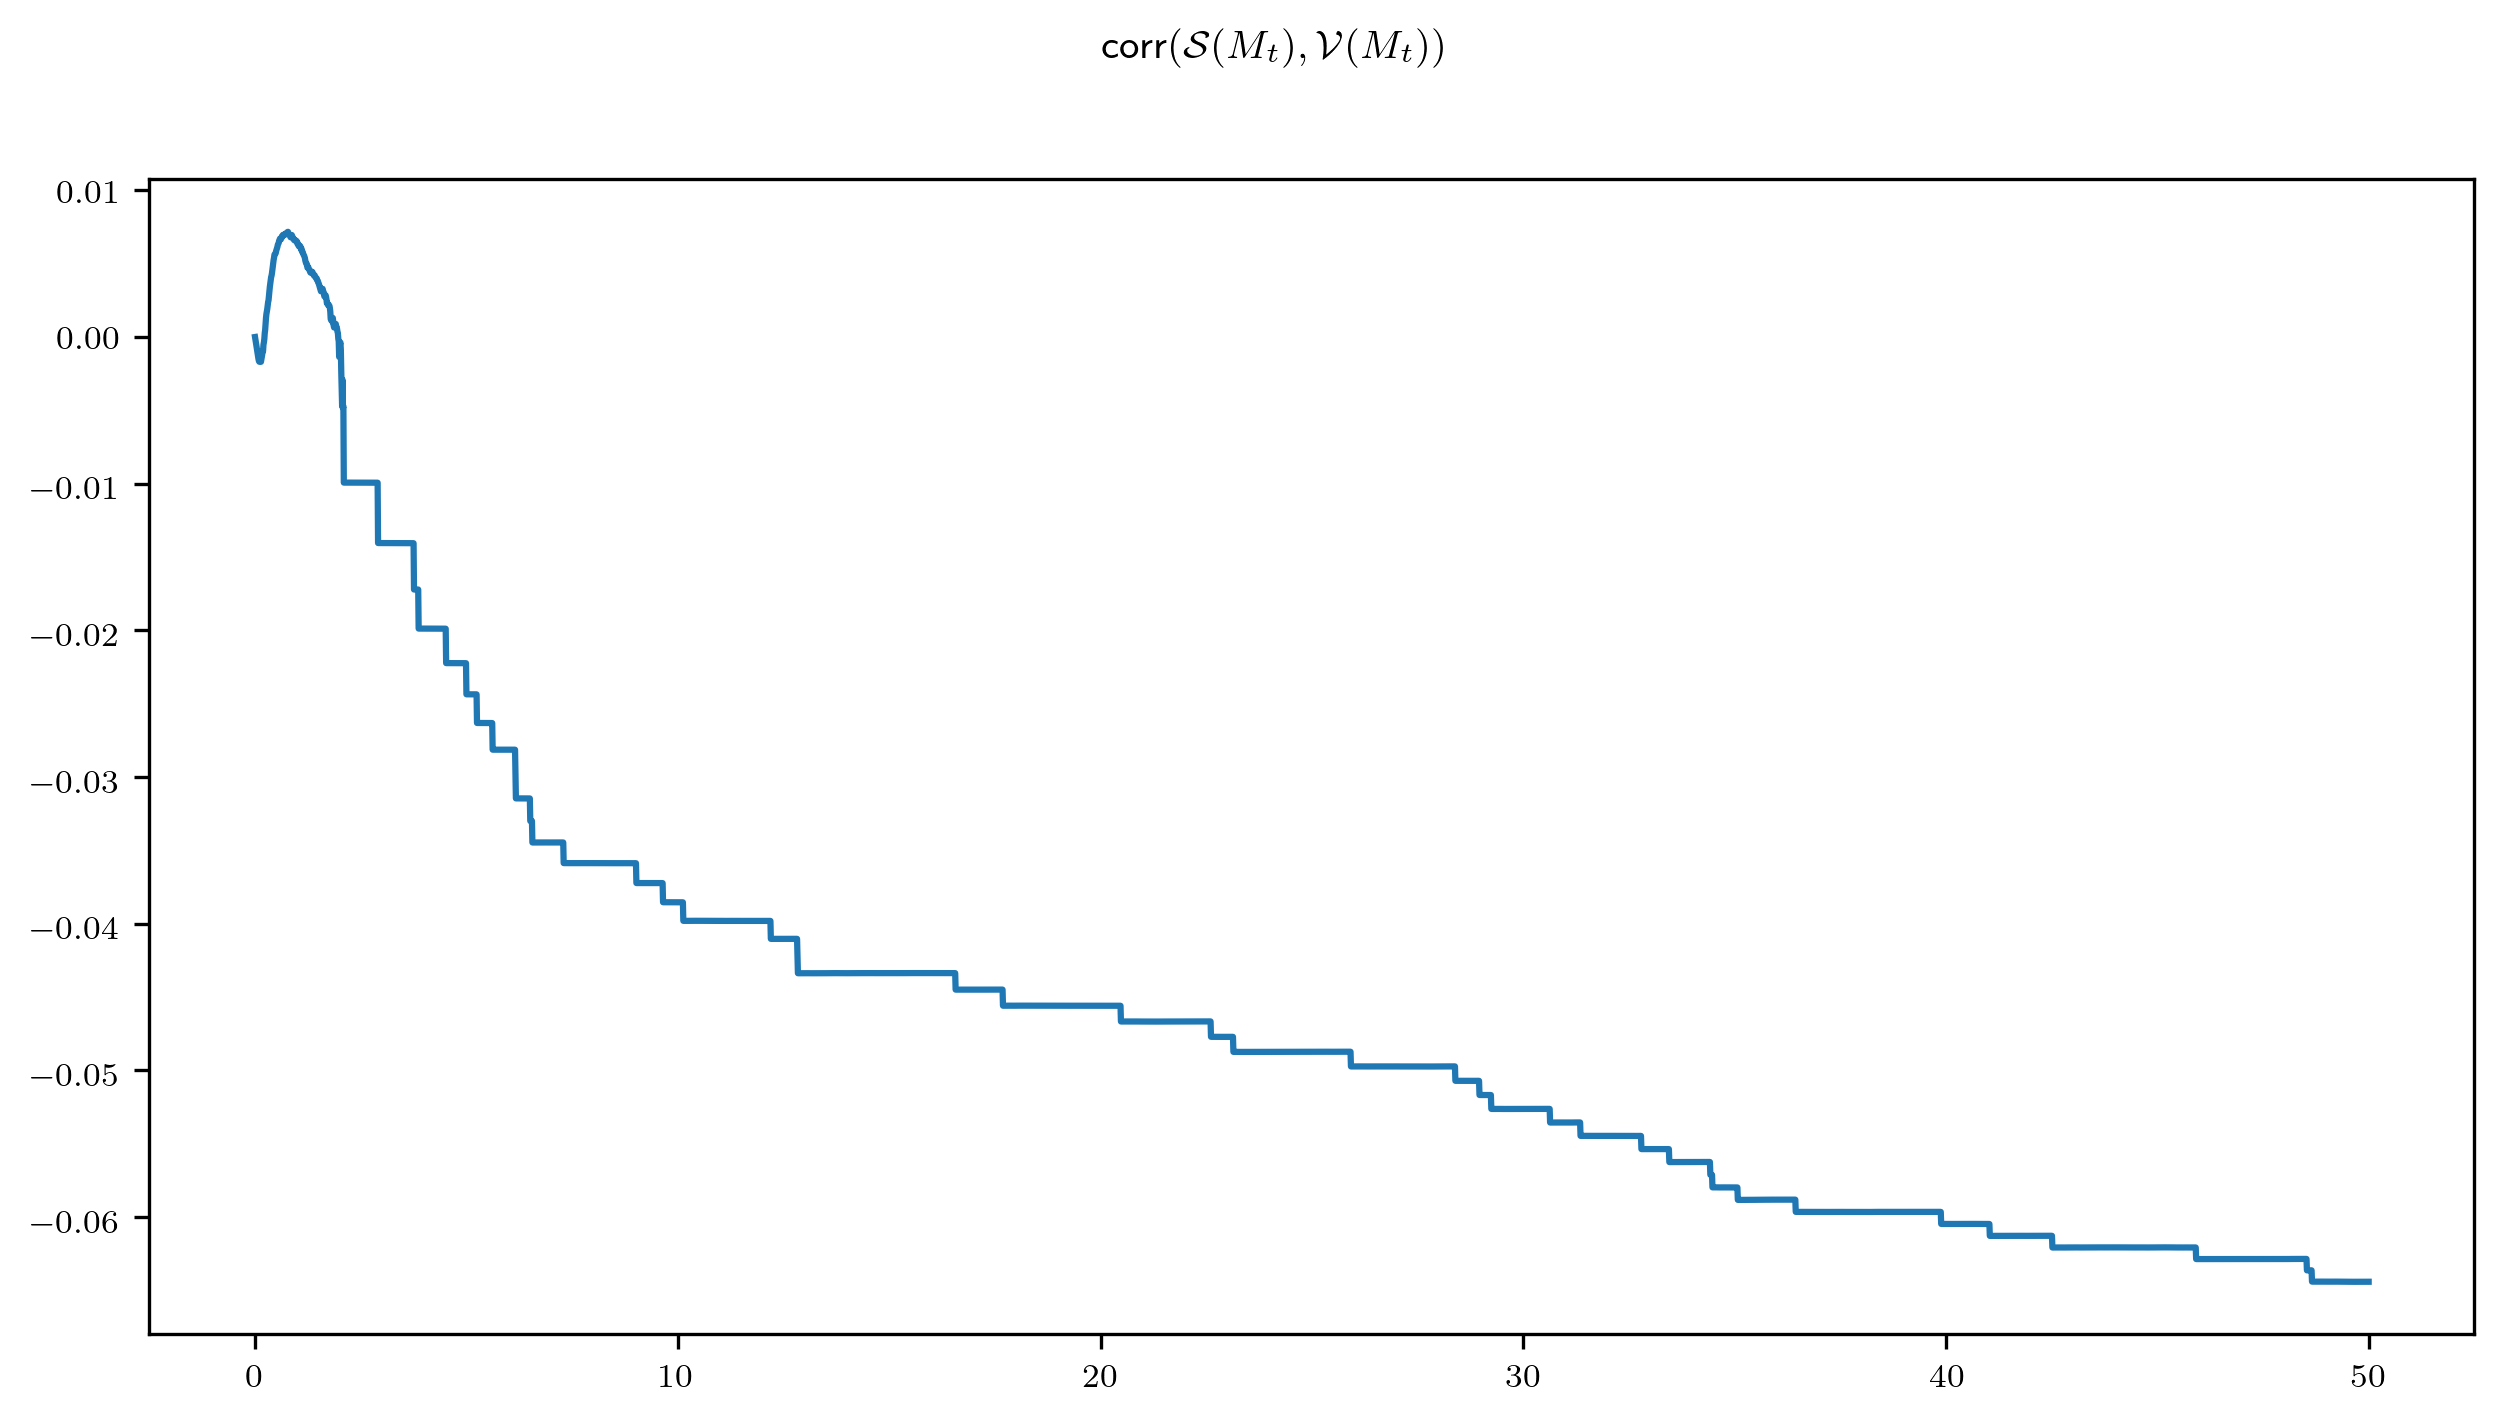

In [135]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((Vol*S).mean(axis=0)-Vol.mean(axis=0)*S.mean(axis=0))/(np.sqrt((Vol*Vol).mean(axis=0))*np.sqrt((S*S).mean(axis=0))),linewidth=1.5);
# Y = np.zeros(X.shape)
# V = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     V[i,:] = vol(X[i,:])
#     Y[i,:] = vol(X[i,:])*SOL.solution_S.sol(X[i,:])[0]
# Svar = np.sqrt((SOL.solution_S.sol(X)[0]*SOL.solution_S.sol(X)[0]).sum(axis=0))    
# Vvar = np.sqrt((V*V).sum(axis=0))
# plt.plot(np.arange(0,T,T/N),Y.mean(axis=0)/(Svar*Vvar),linewidth=1.5);
f.suptitle(r'corr$(\mathcal{S}(M_t),\mathcal{V}(M_t))$');

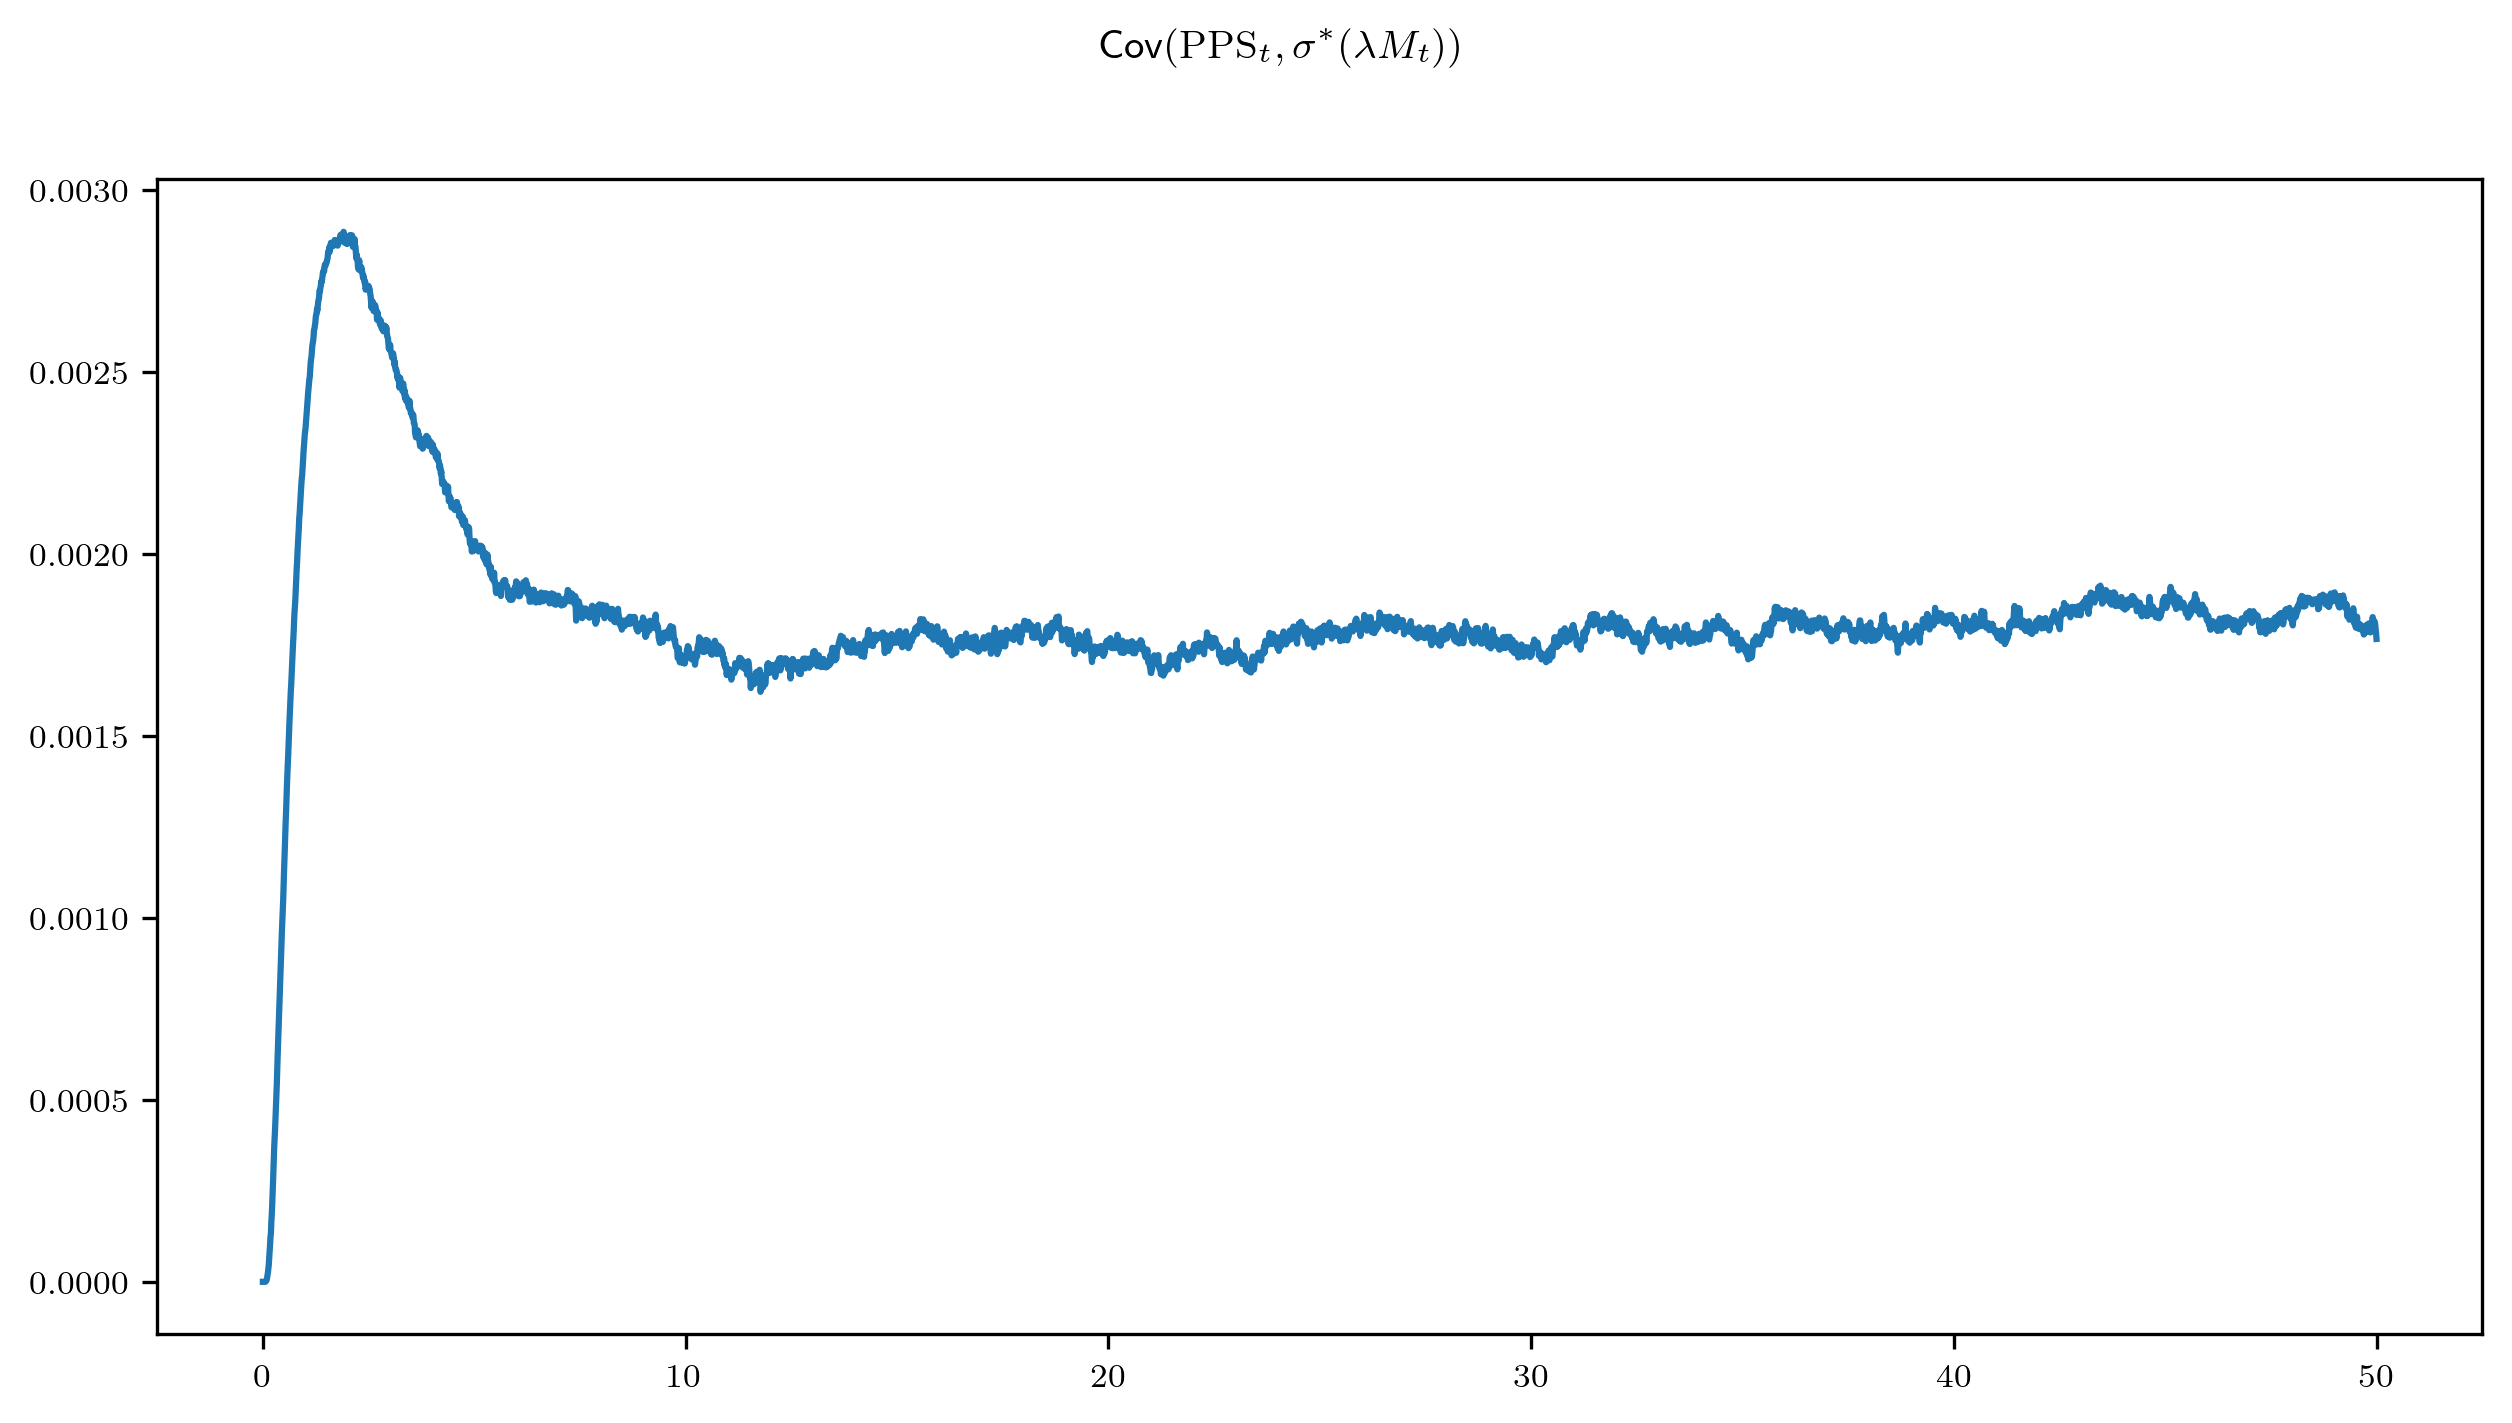

In [136]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((sigma*PPS).mean(axis=0)-sigma.mean(axis=0)*PPS.mean(axis=0)),linewidth=1.5);
f.suptitle(r'Cov$(\textrm{PPS}_t,\sigma^*(\lambda M_t))$');

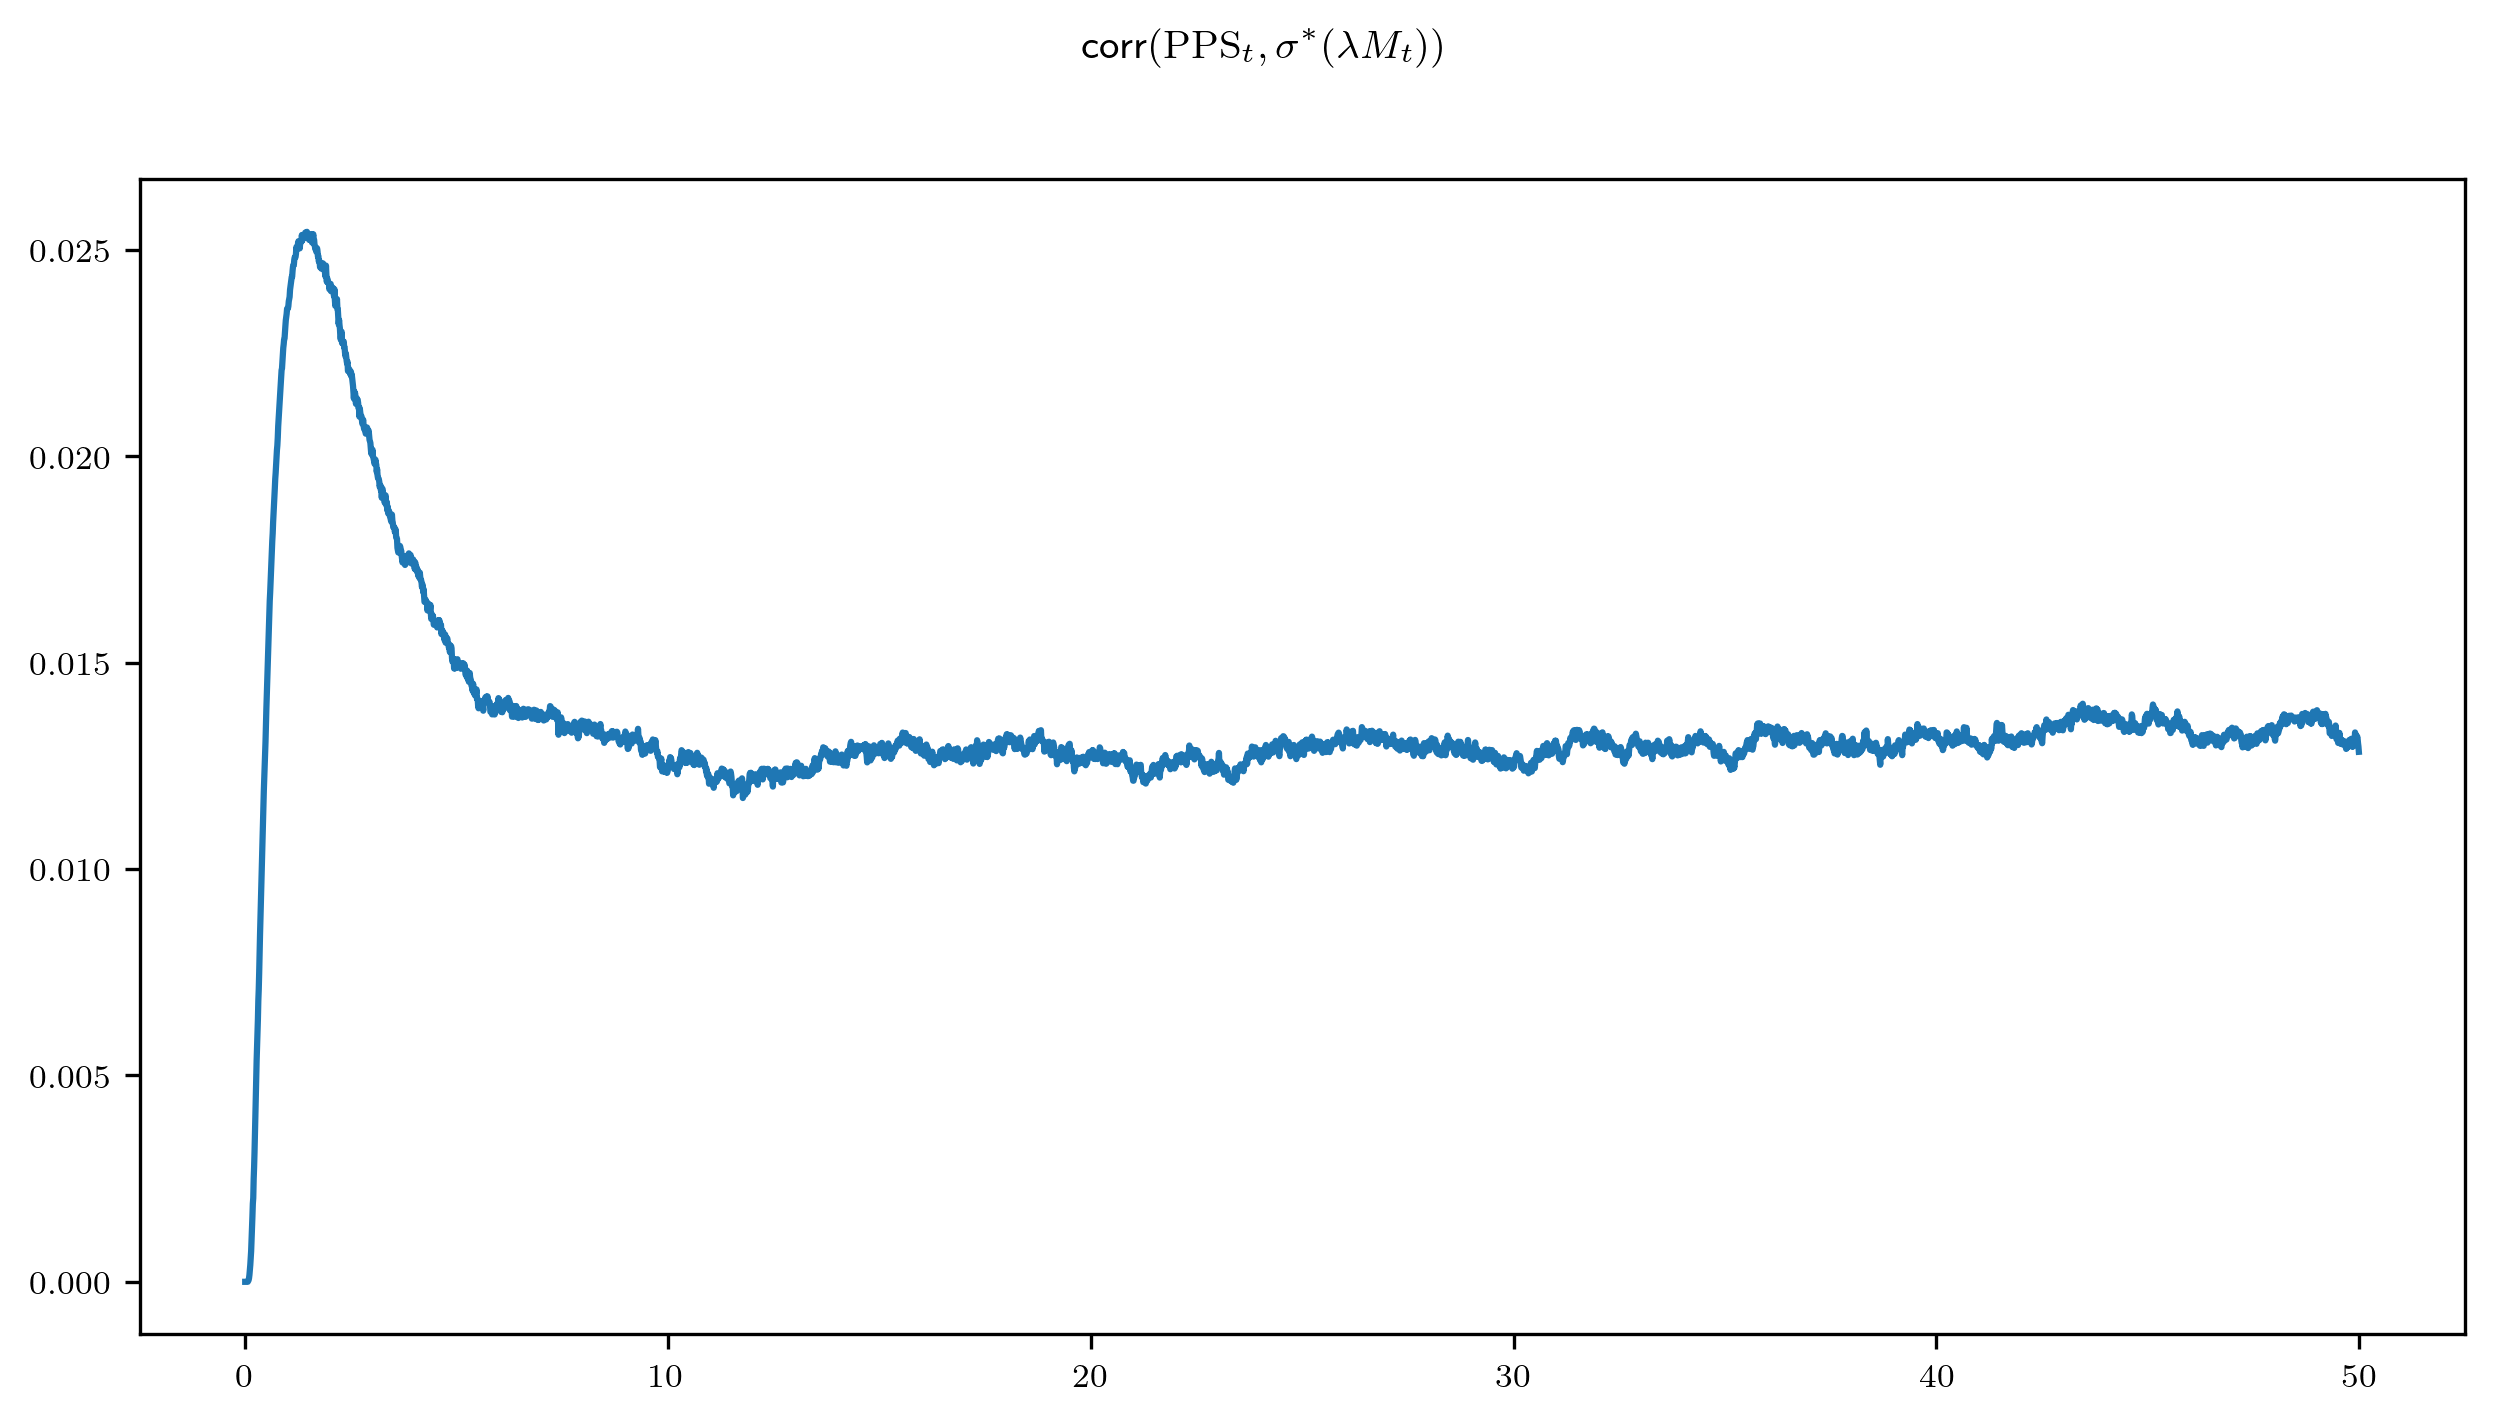

In [137]:
f = plt.figure(figsize=(10,5), dpi=300)
plt.plot(np.arange(0,T,T/N),((sigma*PPS).mean(axis=0)-sigma.mean(axis=0)*PPS.mean(axis=0))/(np.sqrt((sigma*sigma).mean(axis=0))*np.sqrt((PPS*PPS).mean(axis=0))),linewidth=1.5);
f.suptitle(r'corr$(\textrm{PPS}_t,\sigma^*(\lambda M_t))$');